## 測試項目
1. 訓練集中的alarm聲
2. 使用pruned and quantized tflite model
4. export to cc file

In [37]:
import os
import sys
import datetime
import shutil
import numpy as np
import tensorflow as tf
# from tensorflow import keras
import zipfile
import wavio
import audioop
import IPython
from common import utils as U
np.set_printoptions(threshold=sys.maxsize)

In [38]:
from datetime import datetime
import re
import matplotlib.pyplot as plt

### Loading TFlite Model

In [56]:
tflite_quant_model_path = "../../trained_models/step_6_QAT_and_Convert2TFLite/multifold/version_2_use_all_folds/qat_model_uec4C_val93_tr_87_prunInfo_85.0_85.0_DSver15_AllFold_20240730174136.tflite";
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=tflite_quant_model_path, experimental_preserve_all_tensors=True);

In [57]:
# model.summary()
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

tflite_interpreter_quant.allocate_tensors();

== Input details ==
name: input.2_te_transform
shape: [    1     1 20150     1]
type: <class 'numpy.int8'>

== Output details ==
name: Xq.1
shape: [1 4]
type: <class 'numpy.int8'>


### loading dataset from npz format
1. ACDNet input length is 30225
2. sr is 44100 and 20000
3. need to convert 16K to 20000
### ACDNet Config Setting
#### Training Parameters
1. opt.batchSize = 64;
2. opt.weightDecay = 5e-4;
3. opt.momentum = 0.9;
4. opt.nEpochs = 2000;
5. opt.LR = 0.1;
6. opt.schedule = [0.3, 0.6, 0.9];
7. opt.warmup = 10; 
#### Basic Net Configuration
- nClasses = 50
- nFolds = 5
- splits = \[i for in range(1, nFolds + 1)\]
- sr = 20000
- inputLength = 30225
<br>ngth = 30225;
### How to convert 16K sound to 44.1K with python and sox

if using sox the command is as following: <br />
    sox old.wav -b 16 new.wav 
if using python you can do as following: <br />
    import soundfile
    
data, samplerate = soundfile.read('old.wav
    <br />)
soundfile.write('new.wav', data, samplerate, subtype='PCM_1
6')

In [58]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

In [59]:
def getFileList(srcDir,regex='.*\.wav'):
    results = os.listdir(srcDir)
    out_files = []
    cnt_files = 0
    for file in results:
        if os.path.isdir(os.path.join(srcDir, file)):
            out_files += getFileList(os.path.join(srcDir, file))
        elif re.match(regex, file,  re.I):  # file.startswith(startExtension) or file.endswith(".txt") or file.endswith(endExtension):
            out_files.append(os.path.join(srcDir, file))
            cnt_files = cnt_files + 1
    return out_files

In [60]:
def quantize_int8(x, axis):
  '''Quantization into int8_t precision, operating on x along axis'''
  scaling_factor_shape = tuple(np.append([len(x)],np.ones(x.ndim - 1, dtype = int)))
  epsilon = 0.000000001
  x_scaling_factor = (np.max(np.abs(x), axis) / 128) + epsilon
  x_scaling_factor = x_scaling_factor.reshape(scaling_factor_shape)
  # x_zero_offset = -0.5 #-0.25 #-0.25
  result = (x / x_scaling_factor) #+ x_zero_offset
  return np.rint(result).astype(np.int8)

## sound preprocessing functions

In [61]:
_inputLen = 20150
_nCrops = 2
def preprocess_setup():
    funcs = []
    funcs += [U.padding( _inputLen// 2),
              U.normalize(32768.0),
              U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
              # 

    return funcs

def preprocess_debug():
    debug_funcs = []
    debug_funcs += [U.padding( _inputLen// 2),
              U.normalize(32768.0),]
              # U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
    return debug_funcs

def preprocess_setup_help():
    funcs = []
    funcs += [#U.padding(_inputLen//2),
              #U.normalize(32768.0),
              U.multi_crop(_inputLen, _nCrops)]
              # U.single_crop(_inputLen)]
              # 

    return funcs

def preprocess(sound, funcs):
    for f in funcs:
        sound = f(sound)
    return sound;

In [62]:
_funcs = preprocess_setup()
# _debug_funcs = preprocess_debug()

### Read Test Wav File

In [63]:
# print(sounds)
# print(labels)

In [64]:
# print(sounds_1[0][1].shape)
# print(type(labels_1[0]))

In [65]:
# sound = np.expand_dims(sound, axis=1)
# sound = np.expand_dims(sound, axis=3)
# print(sound.shape)

In [66]:
def plot_wav(wavsig):
    plt.plot(wavsig)
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

In [67]:
def padding_sig(sig, pad_length):
    sig = np.pad(sig, (0,pad_length), 'constant')
    return sig

### Test Alarm

In [68]:
def test_alarm():
    positive_test_wavs = "../../datasets/CurrentUse/wav_files/src_wavs/positive/alarm/test_val/alarm/"
    p_wav_list = getFileList(positive_test_wavs);
    print(f"total alarm sounds:{len(p_wav_list)} ");
    p_label = 52;
    n_label = 99;
    sounds_1 = [];
    labels_1 = [];
    
    ## sound = preprocess(sound, _funcs)
    for i in p_wav_list:
        sound = wavio.read(i).data.T[0]
        start = sound.nonzero()[0].min();
        end = sound.nonzero()[0].max();
        sound = sound[start: end + 1]
        label = int(p_label);
        if len(sound)> 220500:
            sound = sound[:220500]
        sound = preprocess(sound, _funcs);
        sounds_1.append(sound);
        labels_1.append(label);
    
    print(f"sound testset 1 length: {len(sounds_1)}");
    
    test1_len = len(sounds_1);
    test1_correct_num = 0;
    test1_wrong_num = 0;
    test_wrong_wav_list = [];
    alarm_idx = 0;
    print(f"index explain:\n0:alarm\n1:moaning\n2:help(English)\n3:other sounds\n***************************************************************************");
    for w in range(test1_len): 
        s = sounds_1[w]
        l = labels_1[w]
        s_test = np.expand_dims(s[0], axis=0);
        s_test = np.expand_dims(s_test, axis=1);
        s_test = np.expand_dims(s_test, axis=3);
        s_test = quantize_int8(s_test,axis=-2);
        
        tflite_interpreter_quant.set_tensor(input_details[0]['index'], s_test);
        tflite_interpreter_quant.invoke()
        pred = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
        pred_idx = np.argmax(pred);
        # print(f"Prediction result shape:{pred.shape}\n");
        print(f"prediction result: {pred}, preediction label:{np.argmax(pred)}, true label: {l}")
        # if l == 52: #positive
        if pred_idx == alarm_idx:
            test1_correct_num += 1;
        else:
            test1_wrong_num += 1;
            test_wrong_wav_list.append(p_wav_list[w]);
    
    print(f"alarm test result is {100*(test1_correct_num/test1_len)}");
    if len(test_wrong_wav_list) > 0:
        print("predict wrong wav files list:")
        for i in test_wrong_wav_list:
            print(f"{i}");


In [69]:
test_alarm()

total alarm sounds:44 
sound testset 1 length: 44
index explain:
0:alarm
1:moaning
2:help(English)
3:other sounds
***************************************************************************
prediction result: [[ -81 -128 -128  -90]], preediction label:0, true label: 52
prediction result: [[ -65 -128 -128  -76]], preediction label:0, true label: 52
prediction result: [[ -93 -128 -128  -99]], preediction label:0, true label: 52
prediction result: [[ -64 -128 -128  -76]], preediction label:0, true label: 52
prediction result: [[ -71 -128 -128  -79]], preediction label:0, true label: 52
prediction result: [[ -80 -128 -128  -89]], preediction label:0, true label: 52
prediction result: [[ -44 -128 -128  -59]], preediction label:0, true label: 52
prediction result: [[ -47 -128 -128  -62]], preediction label:0, true label: 52
prediction result: [[ -87 -128 -128  -95]], preediction label:0, true label: 52
prediction result: [[ -72 -128 -128  -78]], preediction label:0, true label: 52
prediction

### Test Help(English)

In [70]:
def endpoint_detection1(src_signal=None, test_seg_len=2000, threshod=500):
    src_signal_len = len(src_signal)
    current_volume_sum = float(0);
    loopnum = (src_signal_len // test_seg_len)-1; #consider drop out the remaining part
    # detect_value_list = [];
    detected_pos = 0;
    for i in range(loopnum):
        start_pos = i*test_seg_len;
        end_pos = (i+1)*test_seg_len;
        test_seg = src_signal[start_pos:end_pos];
        # energy = int(-(np.sqrt(np.mean(test_seg^2))));##-(np.sqrt(np.mean(test_seg**2)));
        energy = -audioop.rms(test_seg, 2)
        energy_bytes = bytes([energy & 0xFF, (energy >> 8) & 0xFF]);# shift energy right 8 bits and put it in high positions
        # print(f"len of test_seg:{len(test_seg)}, bytes seg:{len(energy_bytes * len(test_seg))}")
        debiased_energy = audioop.rms(audioop.add(test_seg, energy_bytes * len(test_seg), 2),2)
        if debiased_energy < threshod:
            detected_pos = end_pos;
        else:
            if debiased_energy > threshod:
                detected_pos = start_pos;
                return detected_pos
        # detect_value_list.append(debiased_energy);
    return detected_pos

In [73]:
def test_eng_help():
    #settup the preprocessing functions
    _funcs = preprocess_setup_help();
    #set the test english help wav files path
    help_eng_wavs_path = "../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/"
    help_eng_wav_list = getFileList(help_eng_wavs_path);
    all_test_sample_len = len(help_eng_wav_list);
    print(f"Total English Help Speech:{all_test_sample_len}");
    # print("The test wav files are as following:")
    # for i in range(all_test_sample_len):
    #     print(f"{help_eng_wav_list[i]}")
    help_label = 71;
    n_label = 99;
    sounds_help = [];
    labels_help = [];
    print(f"index explain:\n0:alarm\n1:moaning\n2:help(English)\n3:other sounds\n***************************************************************************");
    ## sound = preprocess(sound, _funcs)
    for i in help_eng_wav_list:
        _sound = wavio.read(i).data.T[0]
        start = _sound.nonzero()[0].min();
        end = _sound.nonzero()[0].max();
        _sound = _sound[start: end + 1]
        label = int(help_label);
        if len(_sound)> 220500:
            _sound = _sound[:220500]
        # print("plot _sound before preprocessing");
        # plot_wav(_sound);
        sound = preprocess(_sound, _funcs);
        # print(f"shape of sound:{sound.shape}")
        sounds_help.append(sound);
        labels_help.append(label);
    
    print(f"All English Help Speech Wav Files: {len(help_eng_wav_list)}");
    
    test_correct_num = 0;
    test_wrong_num = 0;
    test_wrong_wav_list = [];
    eng_help_idx = 2;
    print(f"index explain:\n0:alarm\n1:moaning\n2:help(English)\n3:other sounds\n***************************************************************************");
    for w in range(all_test_sample_len): 
        # print(f"current predict wav:{help_eng_wav_list[w]}");
        s = sounds_help[w]
        l = labels_help[w]
        #the following
        s[0].reshape(-1,1);
        s[0] = s[0].T;
        print(f"shape of s[0]:{s[0].shape}")
        #do endpoint detection and modify signal
        silence_endpos = endpoint_detection1(s[0],test_seg_len=200)
        trimed_sig = s[0][silence_endpos:]
        padding_len = len(s[0]) - len(trimed_sig);
        s[0] = padding_sig(trimed_sig, padding_len)
        # plot_wav(s[0])
        # print(f"padding_len:{padding_len}")
        # print(f"trimed_sig len:{len(trimed_sig)}")
        
        # print("plot s0:");
        # plot_wav(s[0]);
        # print("plot s1:");
        # plot_wav(s[1]);
        s_test = np.expand_dims(s[0], axis=0);
        s_test = np.expand_dims(s_test, axis=1);
        s_test = np.expand_dims(s_test, axis=3);
        s_test = quantize_int8(s_test,axis=-2);
        
        tflite_interpreter_quant.set_tensor(input_details[0]['index'], s_test);
        tflite_interpreter_quant.invoke()
        pred = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
        pred_idx = np.argmax(pred);
        # print(f"Prediction result shape:{pred.shape}\n");
        print(f"prediction result: {pred}, preediction label:{np.argmax(pred)}, true label: {l}")
        # if l == 52: #positive
        if pred_idx == eng_help_idx:
            test_correct_num += 1;
        else:
            test_wrong_num += 1;
            test_wrong_wav_list.append(help_eng_wav_list[w]);
    
    print(f"english help speech test result is {100*(test_correct_num/all_test_sample_len)}");
    if len(test_wrong_wav_list) > 0:
        print("predict wrong wav files list:")
        for i in test_wrong_wav_list:
            print(f"{i}");

Total English Help Speech:101
index explain:
0:alarm
1:moaning
2:help(English)
3:other sounds
***************************************************************************
All English Help Speech Wav Files: 101
index explain:
0:alarm
1:moaning
2:help(English)
3:other sounds
***************************************************************************
shape of s[0]:(20150,)


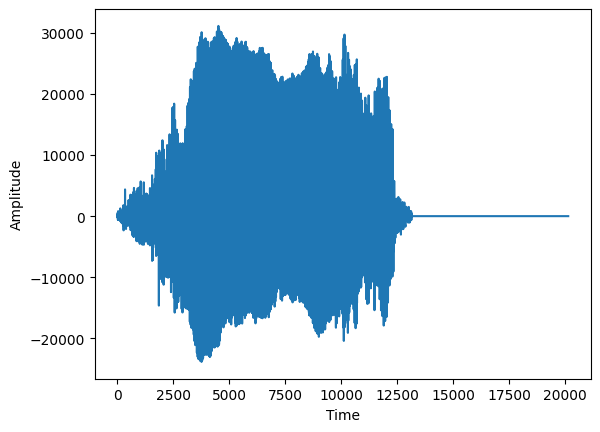

prediction result: [[-111 -128 -118 -106]], preediction label:3, true label: 71
shape of s[0]:(20150,)


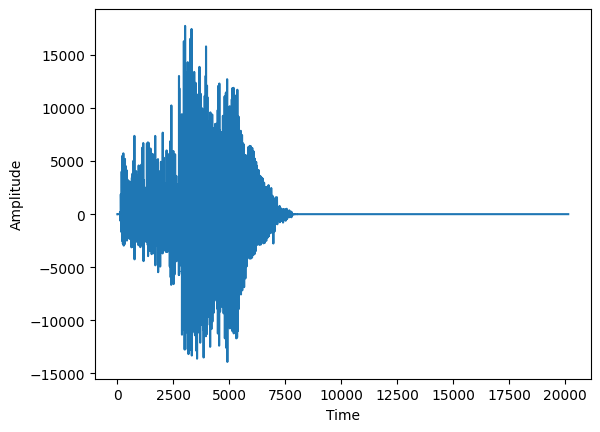

prediction result: [[-128 -128  -68  -87]], preediction label:2, true label: 71
shape of s[0]:(20150,)


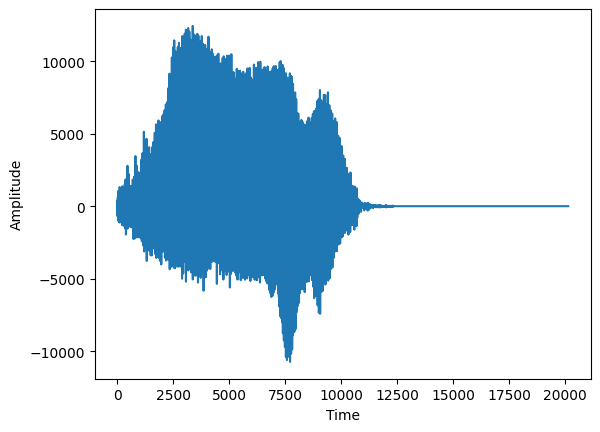

prediction result: [[-121 -128  -69  -87]], preediction label:2, true label: 71
shape of s[0]:(20150,)


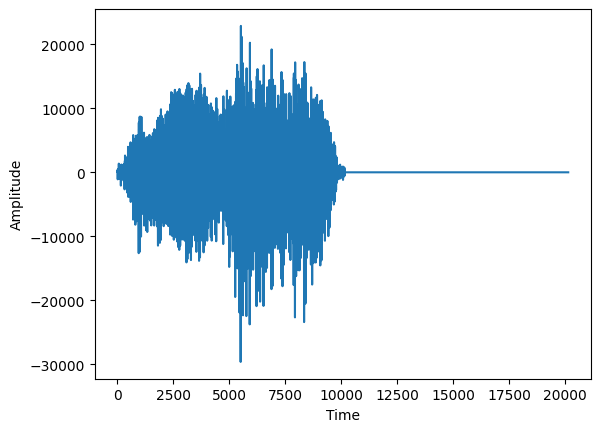

prediction result: [[-119 -128  -88  -98]], preediction label:2, true label: 71
shape of s[0]:(20150,)


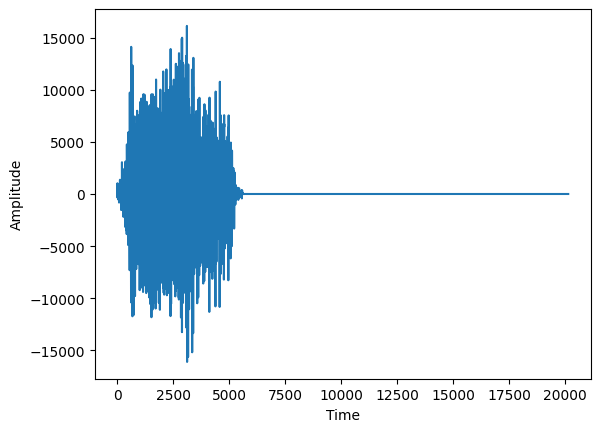

prediction result: [[ -93 -128 -123 -100]], preediction label:0, true label: 71
shape of s[0]:(20150,)


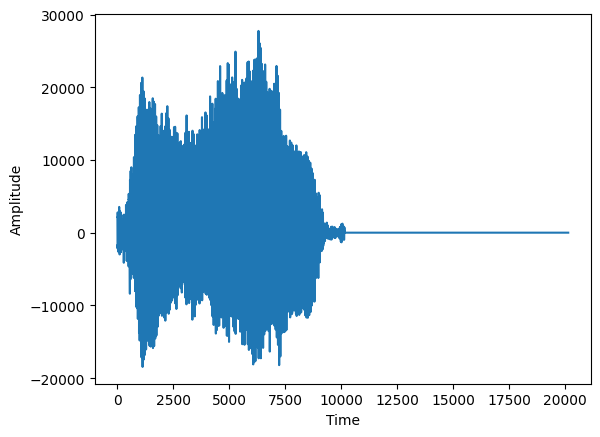

prediction result: [[ -97 -128  -94 -103]], preediction label:2, true label: 71
shape of s[0]:(20150,)


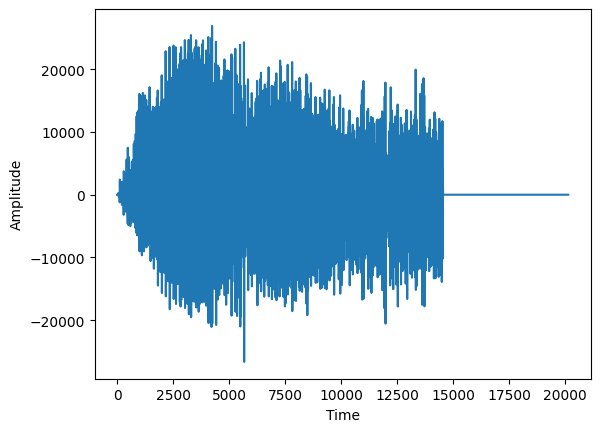

prediction result: [[ -67 -128 -128  -78]], preediction label:0, true label: 71
shape of s[0]:(20150,)


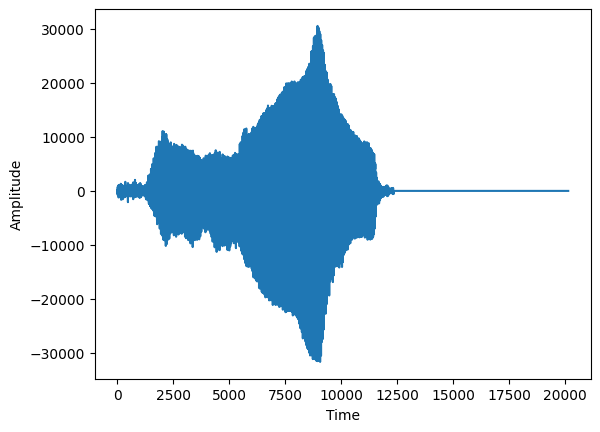

prediction result: [[ -88 -128 -127  -95]], preediction label:0, true label: 71
shape of s[0]:(20150,)


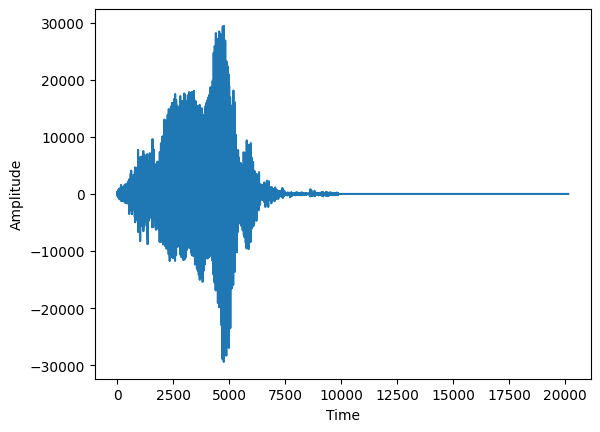

prediction result: [[-110 -128  -86  -97]], preediction label:2, true label: 71
shape of s[0]:(20150,)


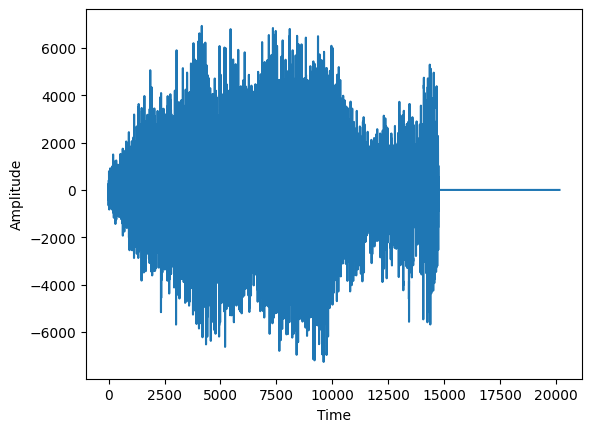

prediction result: [[ -72 -128 -128  -83]], preediction label:0, true label: 71
shape of s[0]:(20150,)


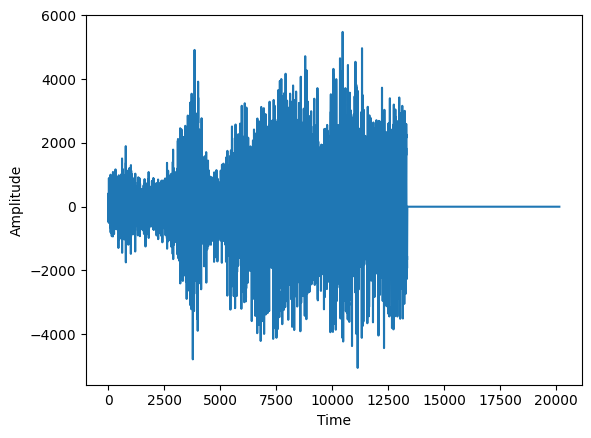

prediction result: [[ -84 -128 -128  -92]], preediction label:0, true label: 71
shape of s[0]:(20150,)


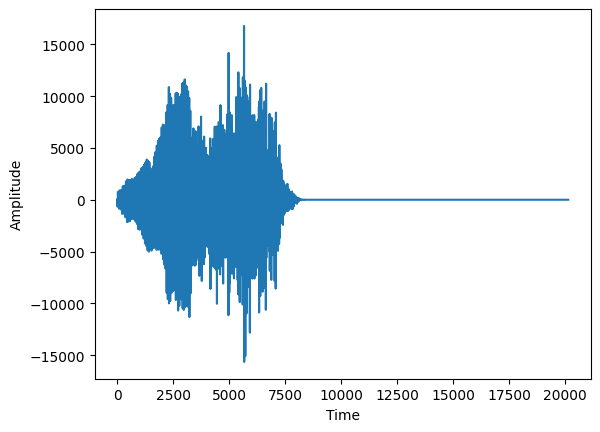

prediction result: [[ -96 -128 -105 -102]], preediction label:0, true label: 71
shape of s[0]:(20150,)


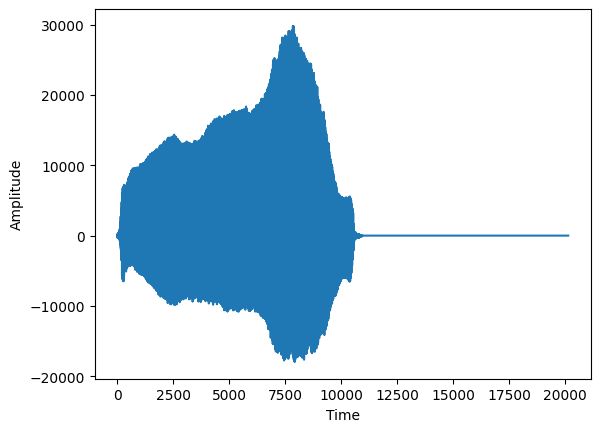

prediction result: [[ -88 -128 -118  -96]], preediction label:0, true label: 71
shape of s[0]:(20150,)


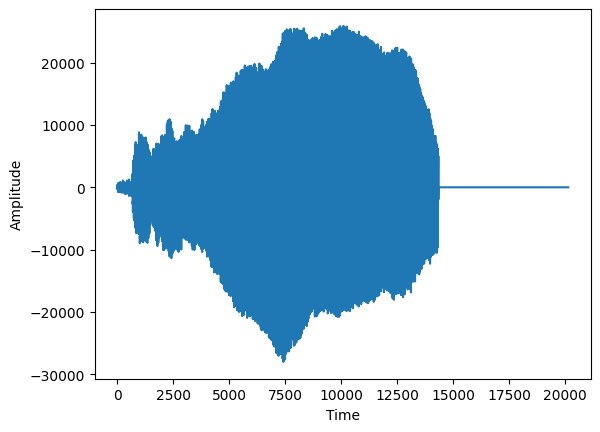

prediction result: [[ -62 -128 -128  -75]], preediction label:0, true label: 71
shape of s[0]:(20150,)


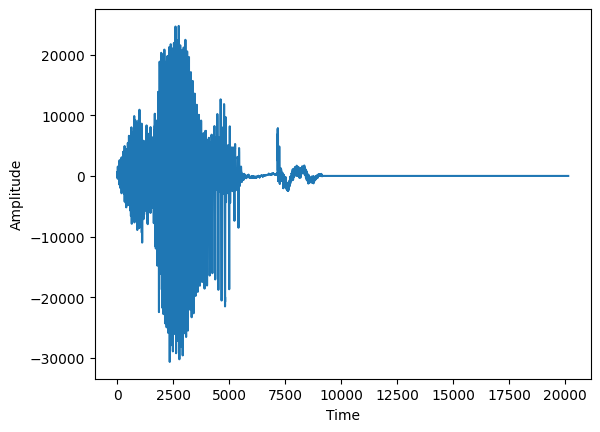

prediction result: [[-125 -128 -106 -107]], preediction label:2, true label: 71
shape of s[0]:(20150,)


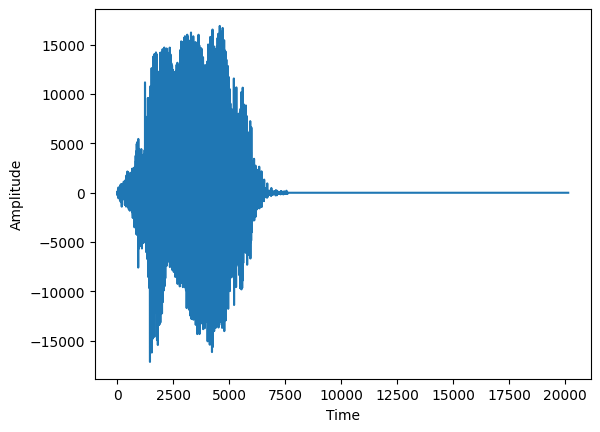

prediction result: [[-103 -128 -100 -107]], preediction label:2, true label: 71
shape of s[0]:(20150,)


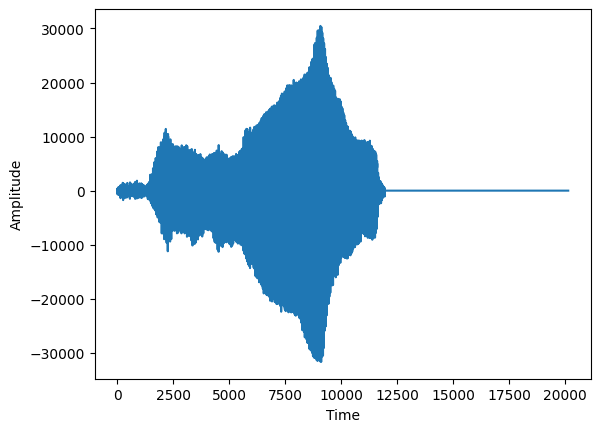

prediction result: [[ -86 -128 -115  -93]], preediction label:0, true label: 71
shape of s[0]:(20150,)


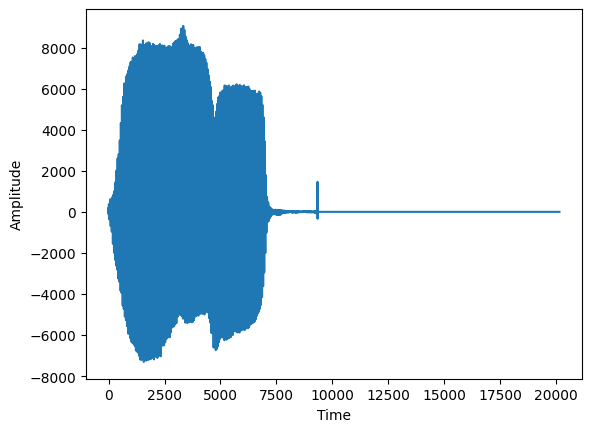

prediction result: [[ -81 -128 -128  -90]], preediction label:0, true label: 71
shape of s[0]:(20150,)


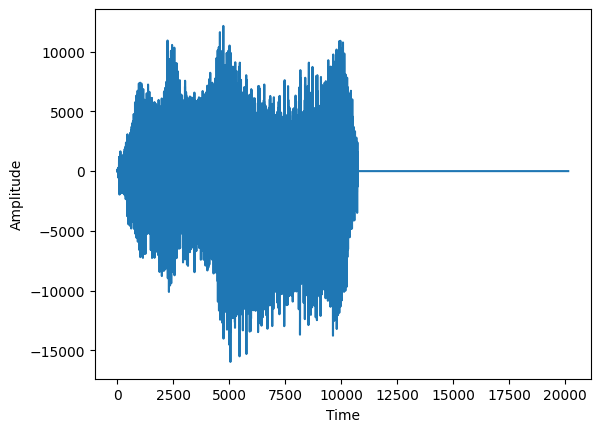

prediction result: [[ -66 -128 -128  -77]], preediction label:0, true label: 71
shape of s[0]:(20150,)


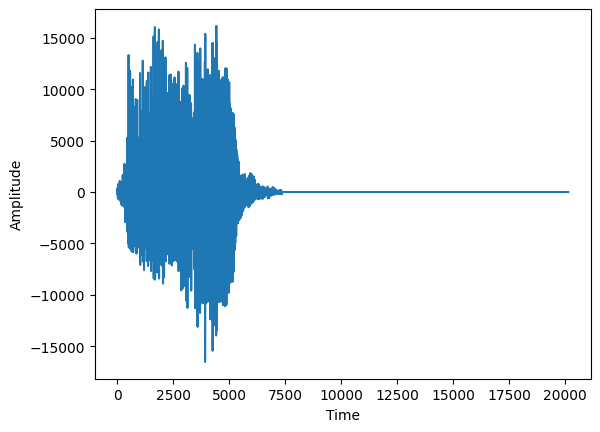

prediction result: [[ -89 -128 -102  -96]], preediction label:0, true label: 71
shape of s[0]:(20150,)


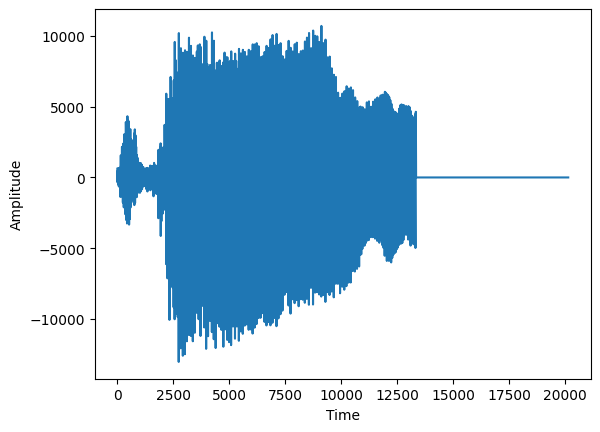

prediction result: [[ -85 -128  -93  -93]], preediction label:0, true label: 71
shape of s[0]:(20150,)


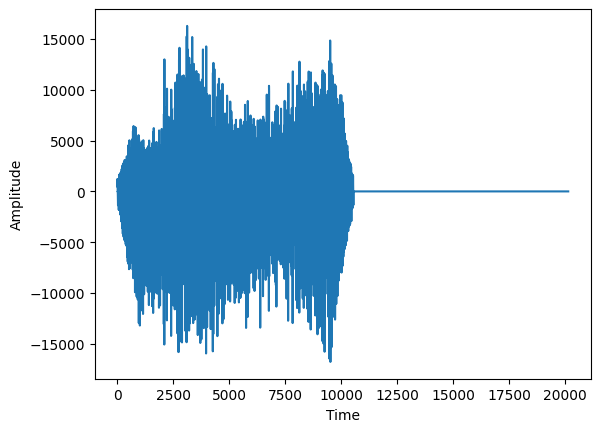

prediction result: [[ -93 -128 -114 -100]], preediction label:0, true label: 71
shape of s[0]:(20150,)


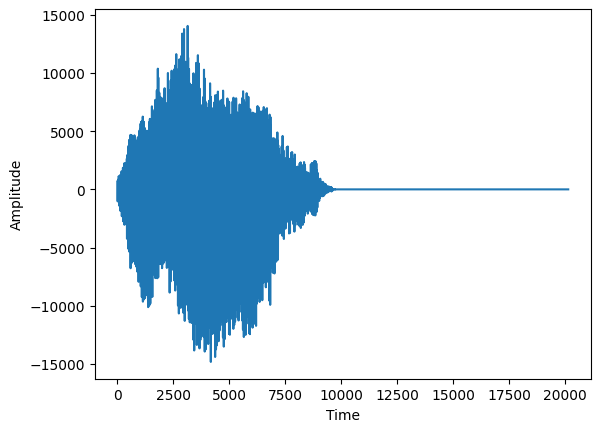

prediction result: [[-108 -128 -106 -112]], preediction label:2, true label: 71
shape of s[0]:(20150,)


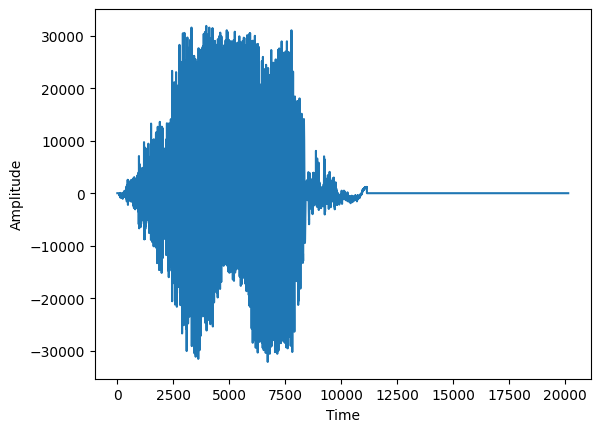

prediction result: [[ -99 -128 -128 -105]], preediction label:0, true label: 71
shape of s[0]:(20150,)


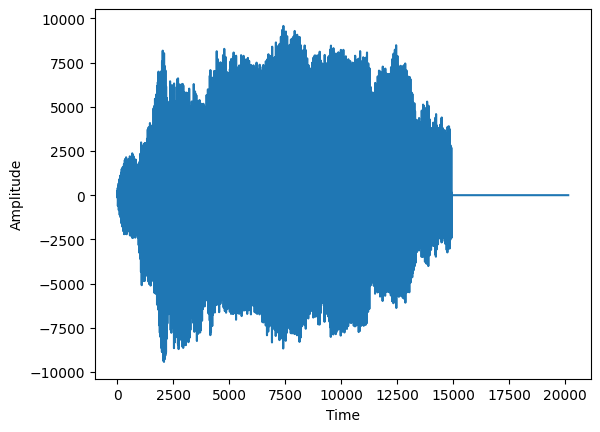

prediction result: [[ -66 -128 -128  -78]], preediction label:0, true label: 71
shape of s[0]:(20150,)


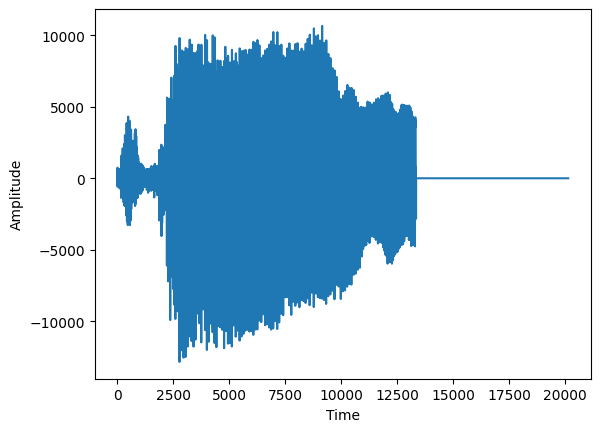

prediction result: [[ -87 -128 -104  -93]], preediction label:0, true label: 71
shape of s[0]:(20150,)


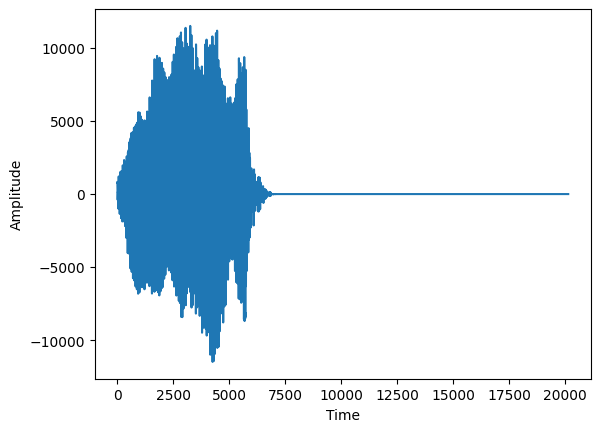

prediction result: [[-104 -128 -101 -108]], preediction label:2, true label: 71
shape of s[0]:(20150,)


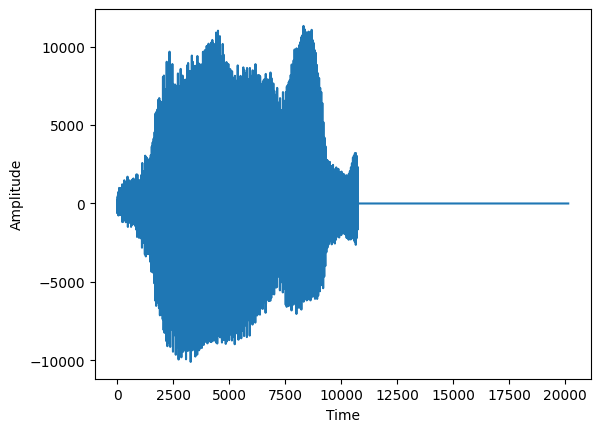

prediction result: [[ -78 -128 -128  -88]], preediction label:0, true label: 71
shape of s[0]:(20150,)


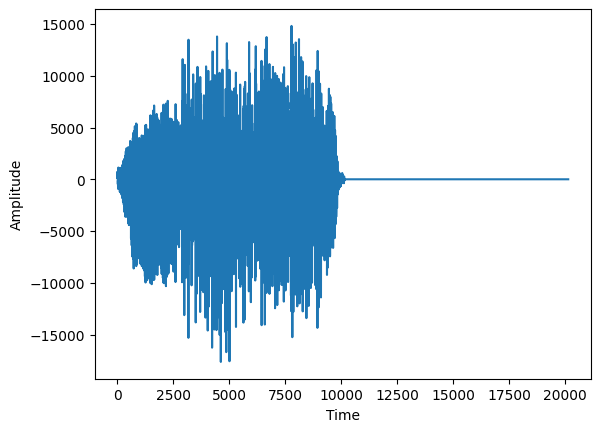

prediction result: [[-109 -128 -105 -111]], preediction label:2, true label: 71
shape of s[0]:(20150,)


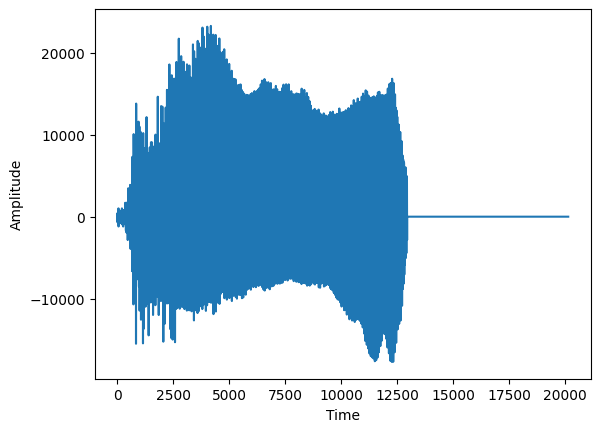

prediction result: [[ -88 -128 -125  -96]], preediction label:0, true label: 71
shape of s[0]:(20150,)


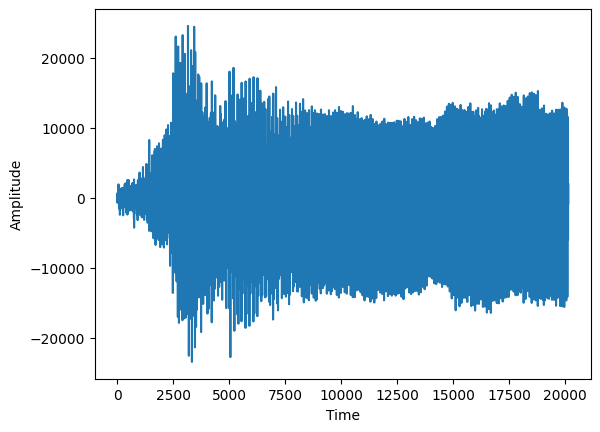

prediction result: [[ -57 -128 -128  -70]], preediction label:0, true label: 71
shape of s[0]:(20150,)


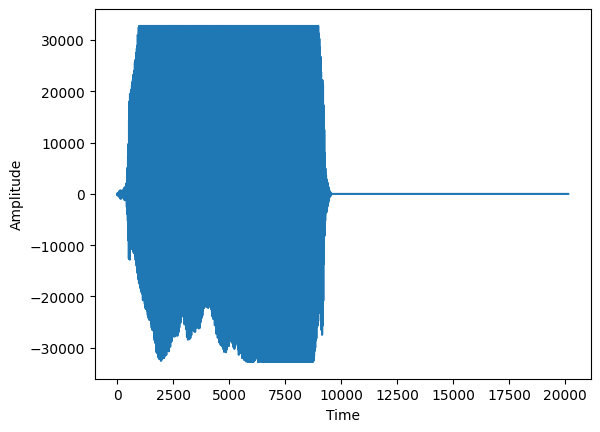

prediction result: [[-100 -128 -128 -105]], preediction label:0, true label: 71
shape of s[0]:(20150,)


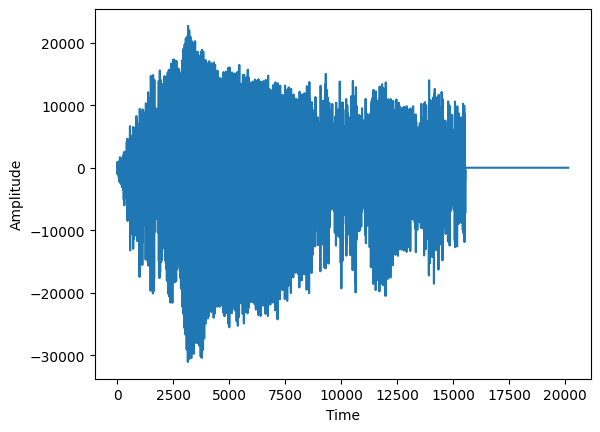

prediction result: [[ -46 -128 -128  -61]], preediction label:0, true label: 71
shape of s[0]:(20150,)


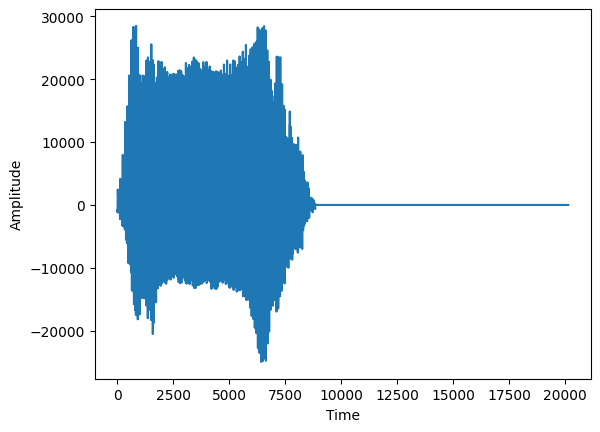

prediction result: [[-106 -128  -74  -89]], preediction label:2, true label: 71
shape of s[0]:(20150,)


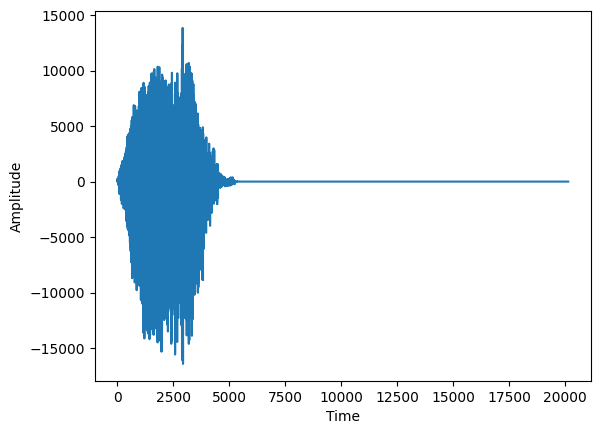

prediction result: [[-110 -128 -127 -114]], preediction label:0, true label: 71
shape of s[0]:(20150,)


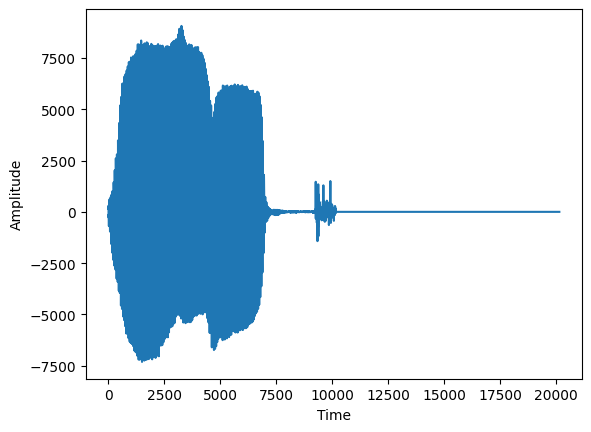

prediction result: [[ -78 -128 -128  -87]], preediction label:0, true label: 71
shape of s[0]:(20150,)


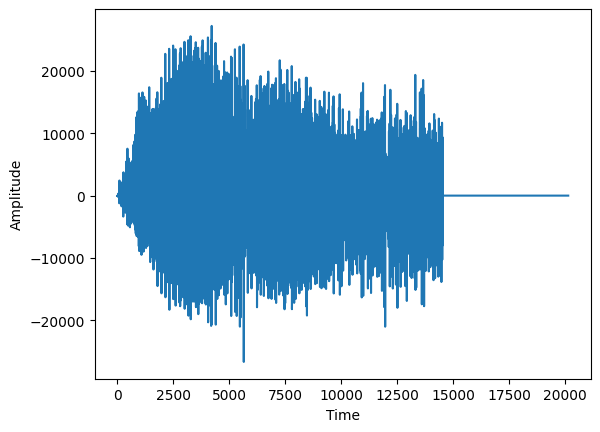

prediction result: [[ -59 -128 -128  -72]], preediction label:0, true label: 71
shape of s[0]:(20150,)


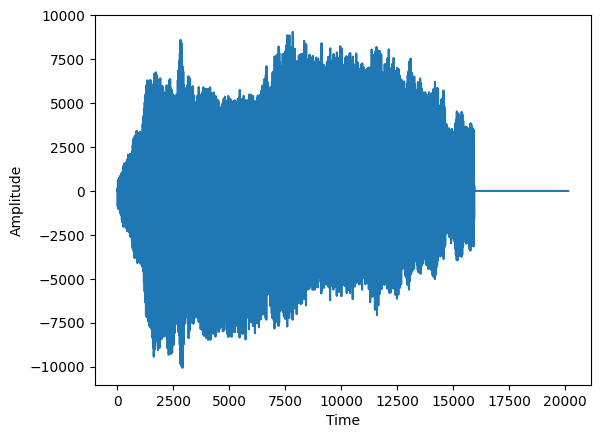

prediction result: [[ -83 -128 -128  -91]], preediction label:0, true label: 71
shape of s[0]:(20150,)


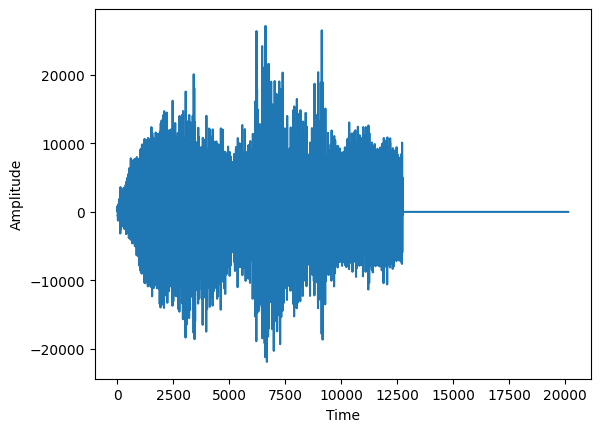

prediction result: [[ -77 -128 -128  -87]], preediction label:0, true label: 71
shape of s[0]:(20150,)


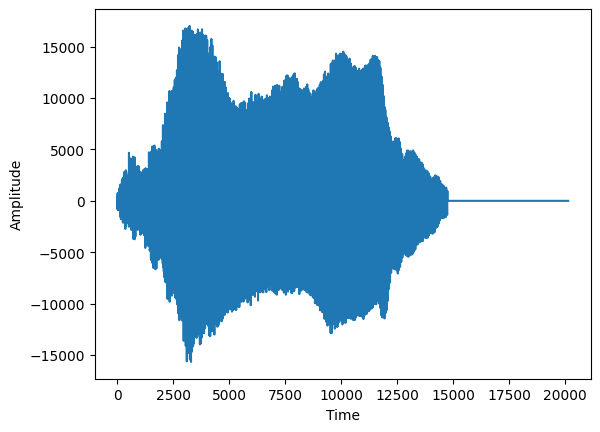

prediction result: [[ -93 -128 -113  -91]], preediction label:3, true label: 71
shape of s[0]:(20150,)


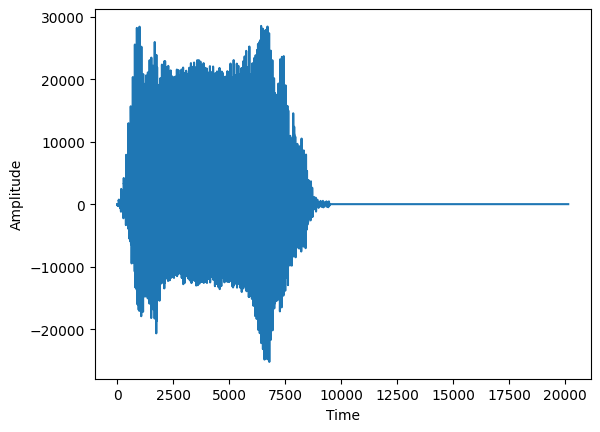

prediction result: [[ -96 -128  -93 -102]], preediction label:2, true label: 71
shape of s[0]:(20150,)


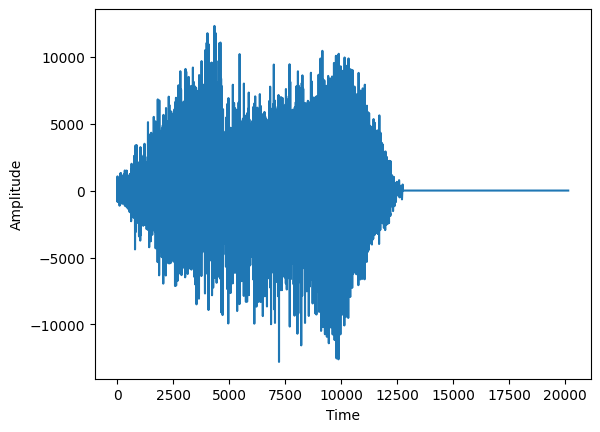

prediction result: [[ -88 -128 -128  -95]], preediction label:0, true label: 71
shape of s[0]:(20150,)


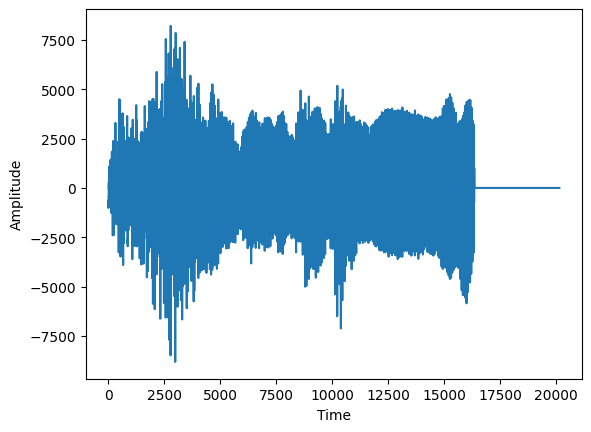

prediction result: [[ -86 -128 -128  -94]], preediction label:0, true label: 71
shape of s[0]:(20150,)


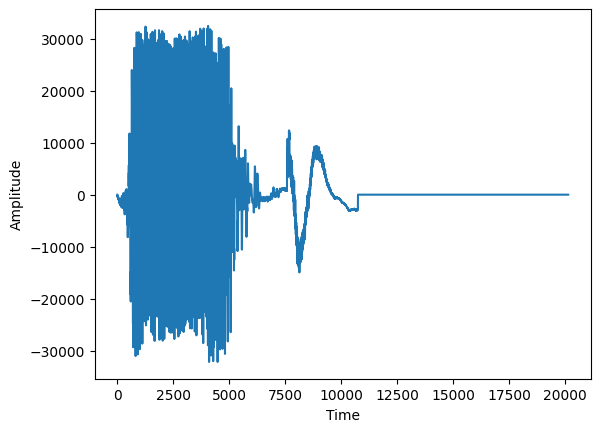

prediction result: [[ -78 -128 -128  -88]], preediction label:0, true label: 71
shape of s[0]:(20150,)


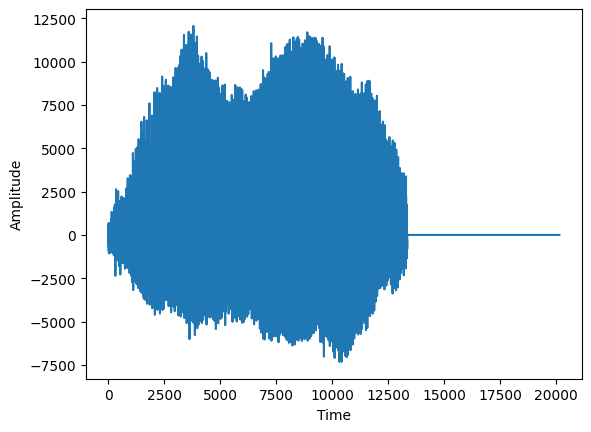

prediction result: [[-109 -128  -74  -87]], preediction label:2, true label: 71
shape of s[0]:(20150,)


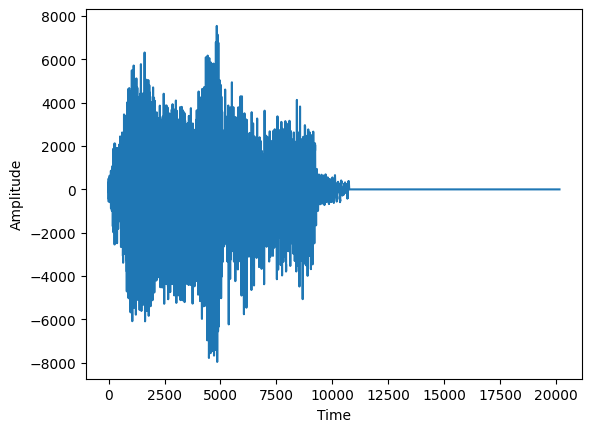

prediction result: [[ -67 -128 -128  -78]], preediction label:0, true label: 71
shape of s[0]:(20150,)


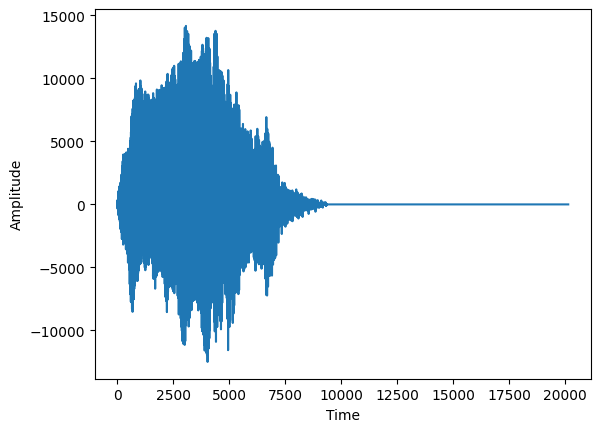

prediction result: [[-110 -128 -117 -113]], preediction label:0, true label: 71
shape of s[0]:(20150,)


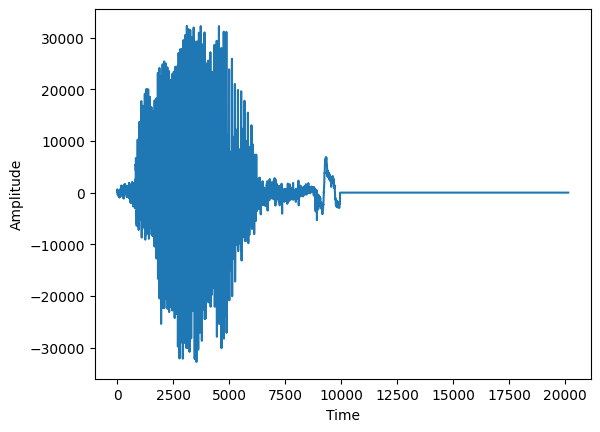

prediction result: [[-118 -128 -119 -112]], preediction label:3, true label: 71
shape of s[0]:(20150,)


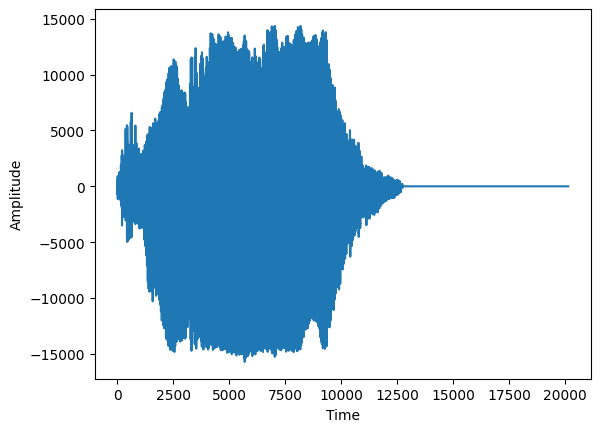

prediction result: [[-118 -128  -99 -108]], preediction label:2, true label: 71
shape of s[0]:(20150,)


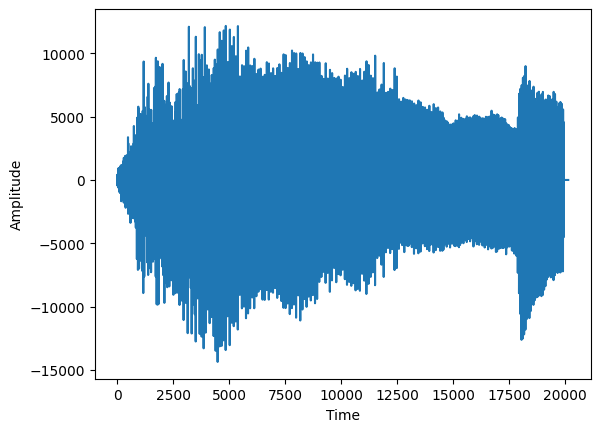

prediction result: [[ -69 -128 -128  -80]], preediction label:0, true label: 71
shape of s[0]:(20150,)


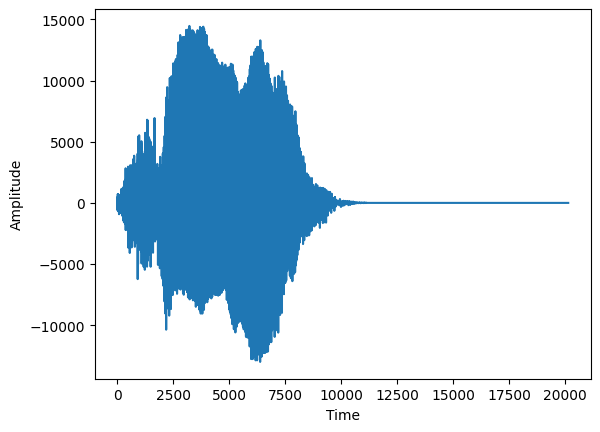

prediction result: [[-128 -128  -81  -88]], preediction label:2, true label: 71
shape of s[0]:(20150,)


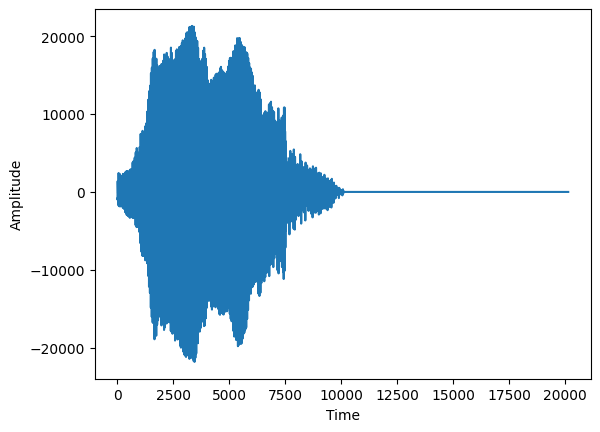

prediction result: [[-128 -128  -94 -104]], preediction label:2, true label: 71
shape of s[0]:(20150,)


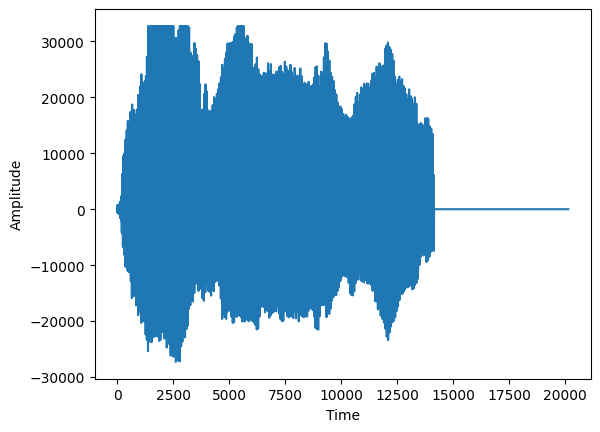

prediction result: [[ -58 -128 -128  -71]], preediction label:0, true label: 71
shape of s[0]:(20150,)


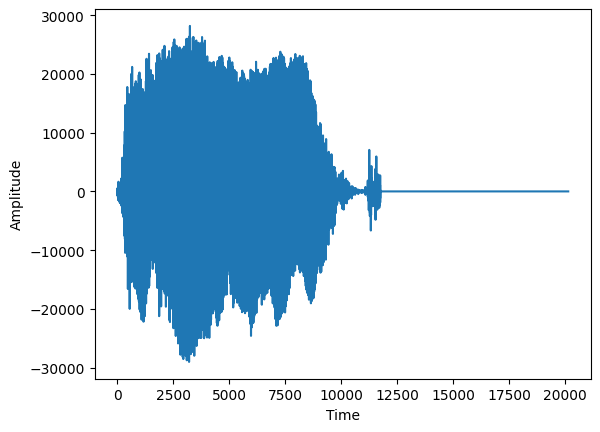

prediction result: [[-105 -128 -111 -110]], preediction label:0, true label: 71
shape of s[0]:(20150,)


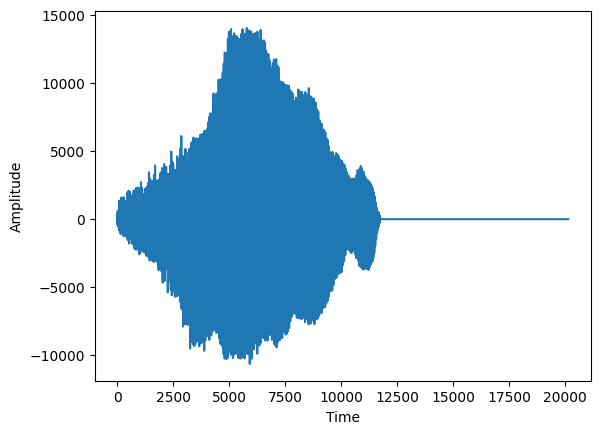

prediction result: [[-106 -128 -128 -110]], preediction label:0, true label: 71
shape of s[0]:(20150,)


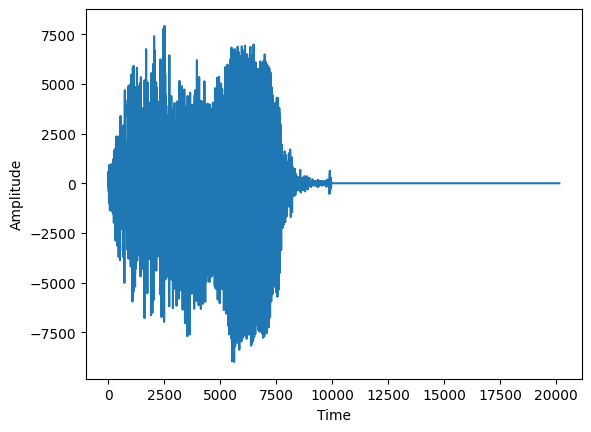

prediction result: [[ -93 -128 -128 -100]], preediction label:0, true label: 71
shape of s[0]:(20150,)


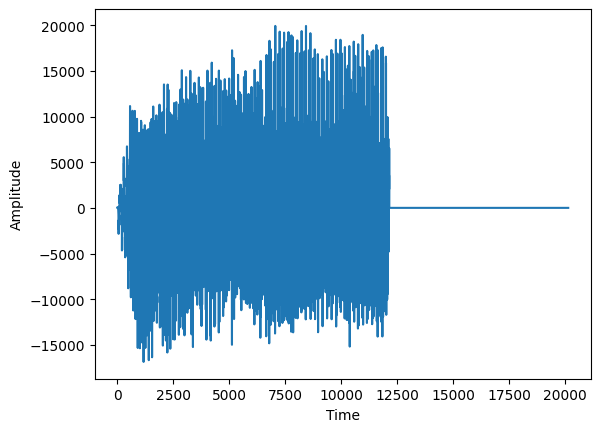

prediction result: [[ -62 -128 -128  -74]], preediction label:0, true label: 71
shape of s[0]:(20150,)


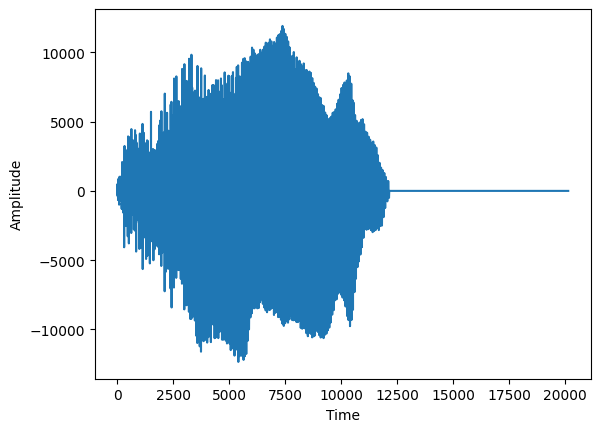

prediction result: [[ -71 -128 -128  -81]], preediction label:0, true label: 71
shape of s[0]:(20150,)


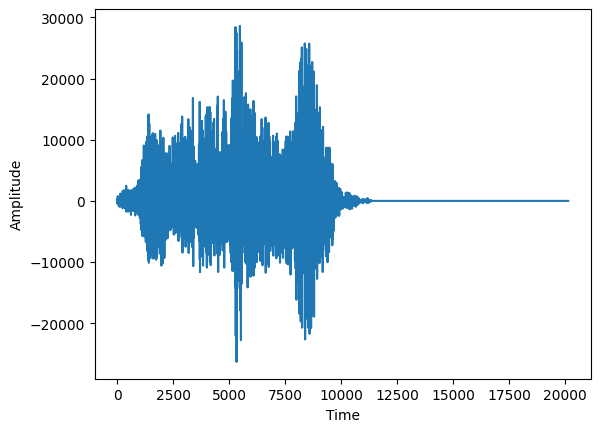

prediction result: [[-128 -128  -66  -78]], preediction label:2, true label: 71
shape of s[0]:(20150,)


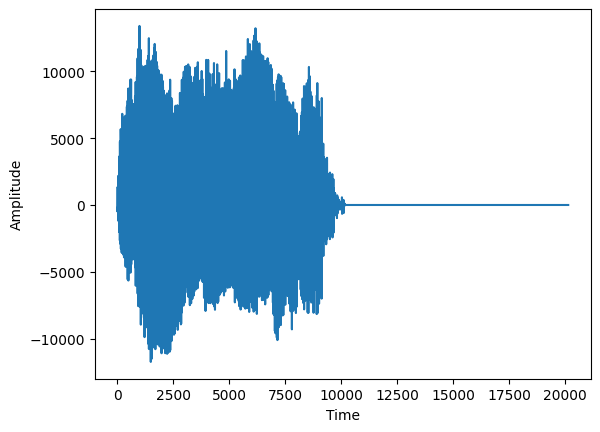

prediction result: [[-104 -128 -102 -109]], preediction label:2, true label: 71
shape of s[0]:(20150,)


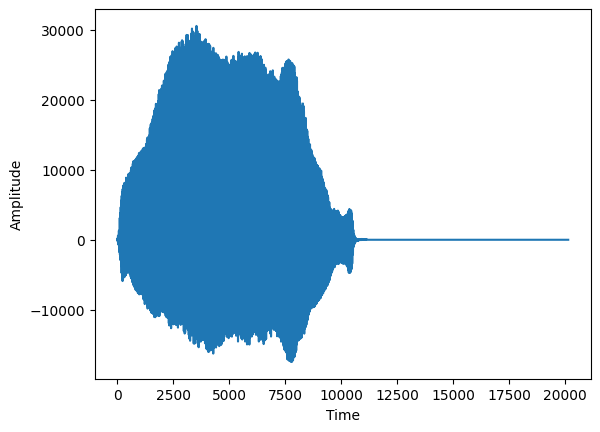

prediction result: [[-107 -128 -126 -111]], preediction label:0, true label: 71
shape of s[0]:(20150,)


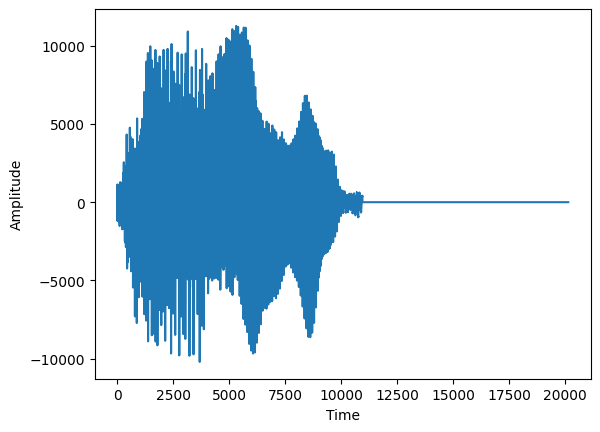

prediction result: [[ -93 -128 -127  -99]], preediction label:0, true label: 71
shape of s[0]:(20150,)


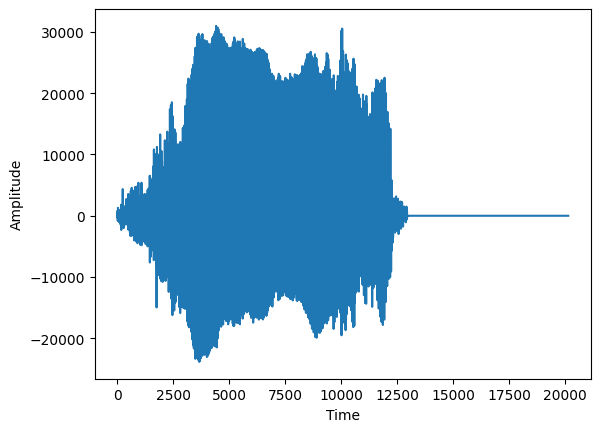

prediction result: [[-111 -128 -109 -114]], preediction label:2, true label: 71
shape of s[0]:(20150,)


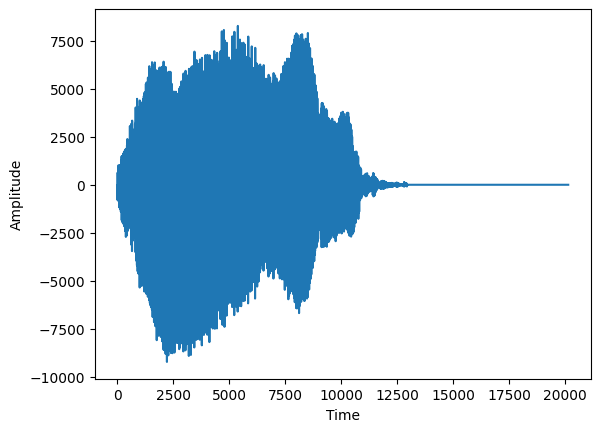

prediction result: [[ -94 -128  -90 -100]], preediction label:2, true label: 71
shape of s[0]:(20150,)


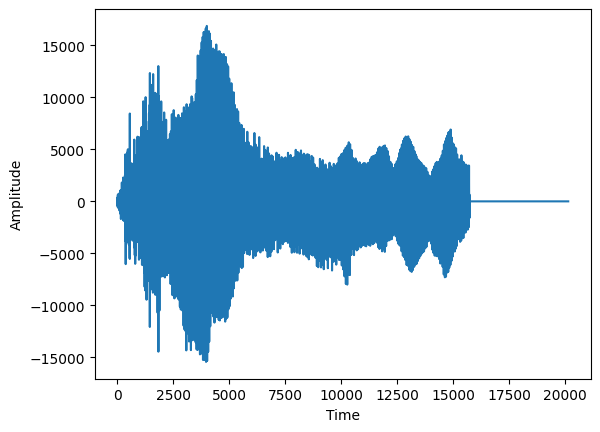

prediction result: [[-101 -128 -128 -106]], preediction label:0, true label: 71
shape of s[0]:(20150,)


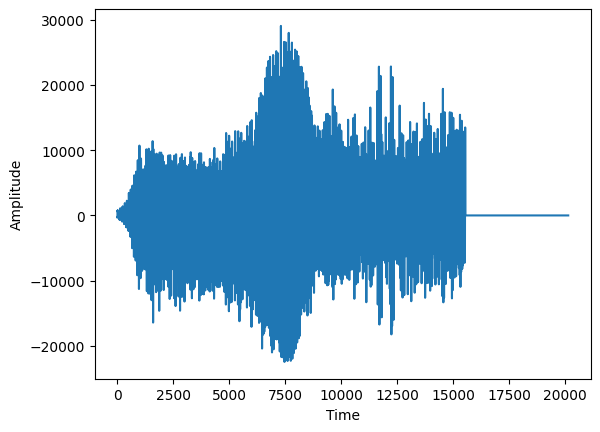

prediction result: [[ -58 -128 -128  -71]], preediction label:0, true label: 71
shape of s[0]:(20150,)


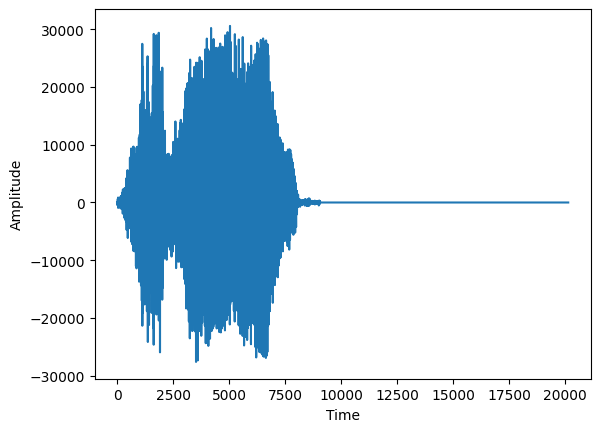

prediction result: [[-104 -128 -104 -109]], preediction label:0, true label: 71
shape of s[0]:(20150,)


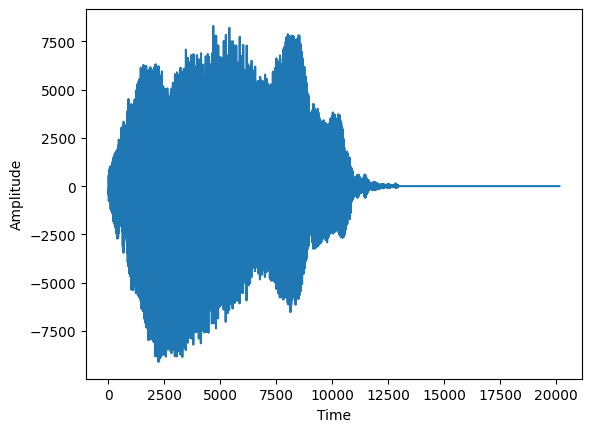

prediction result: [[ -92 -128  -86  -96]], preediction label:2, true label: 71
shape of s[0]:(20150,)


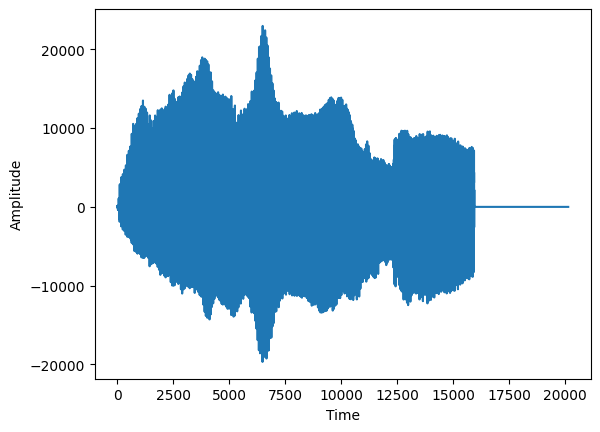

prediction result: [[ -78 -128 -106  -87]], preediction label:0, true label: 71
shape of s[0]:(20150,)


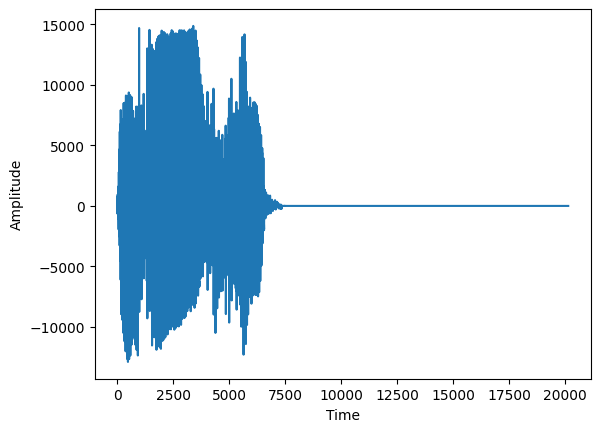

prediction result: [[ -98 -128  -92 -101]], preediction label:2, true label: 71
shape of s[0]:(20150,)


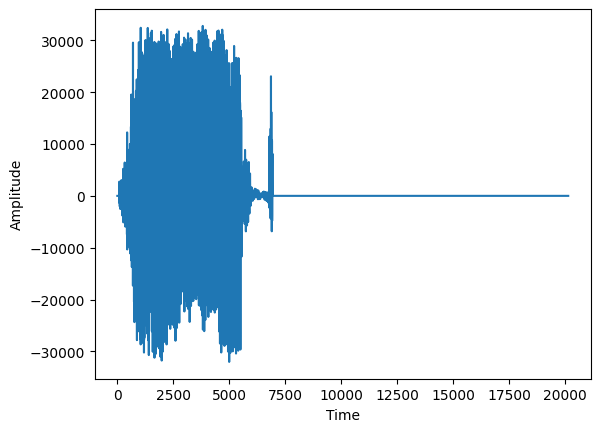

prediction result: [[-123 -128  -84  -92]], preediction label:2, true label: 71
shape of s[0]:(20150,)


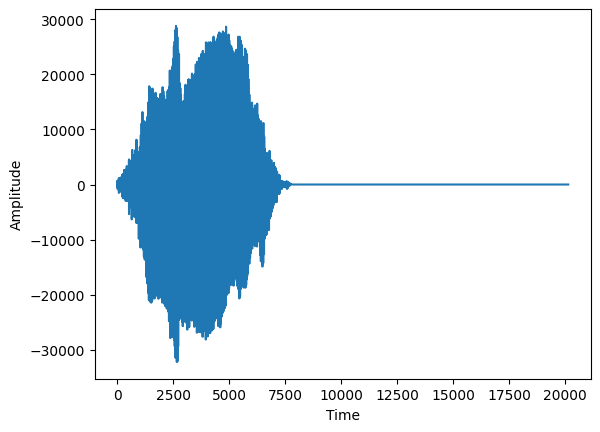

prediction result: [[-128 -128  -71  -83]], preediction label:2, true label: 71
shape of s[0]:(20150,)


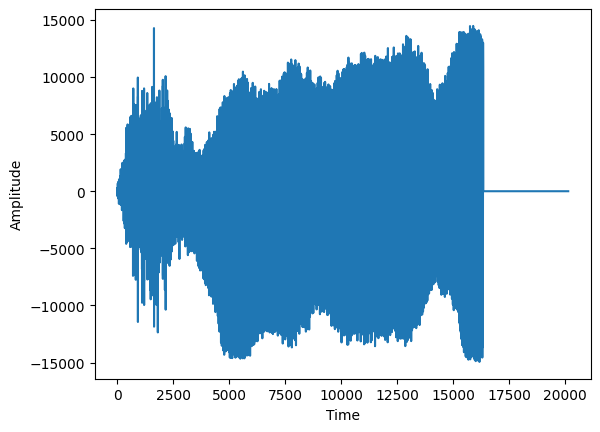

prediction result: [[ -63 -128 -128  -75]], preediction label:0, true label: 71
shape of s[0]:(20150,)


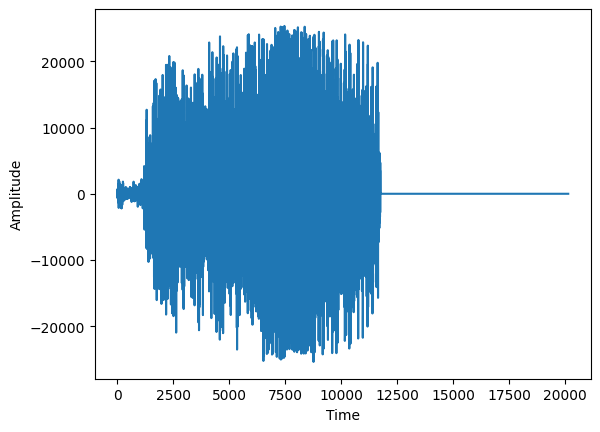

prediction result: [[ -62 -128 -128  -74]], preediction label:0, true label: 71
shape of s[0]:(20150,)


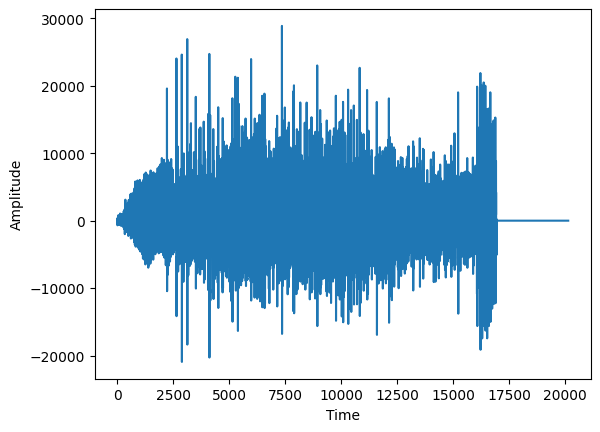

prediction result: [[ -94 -128 -128 -100]], preediction label:0, true label: 71
shape of s[0]:(20150,)


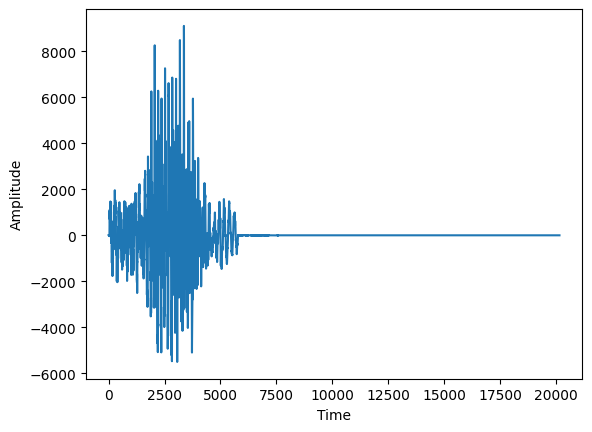

prediction result: [[-117 -128 -128 -116]], preediction label:3, true label: 71
shape of s[0]:(20150,)


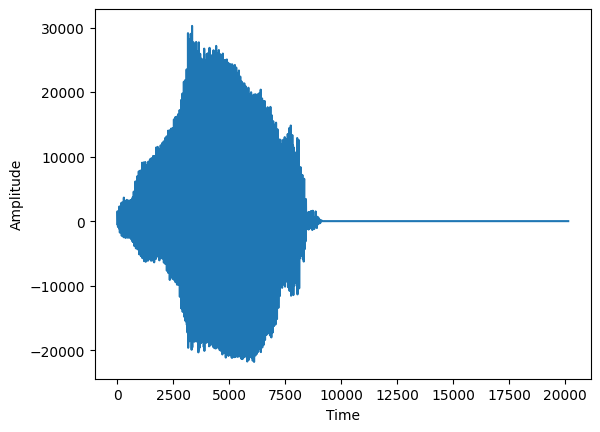

prediction result: [[-100 -128 -128 -105]], preediction label:0, true label: 71
shape of s[0]:(20150,)


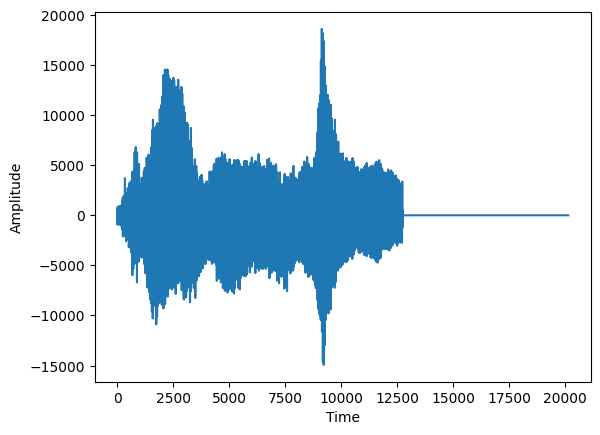

prediction result: [[-128 -128  -51  -67]], preediction label:2, true label: 71
shape of s[0]:(20150,)


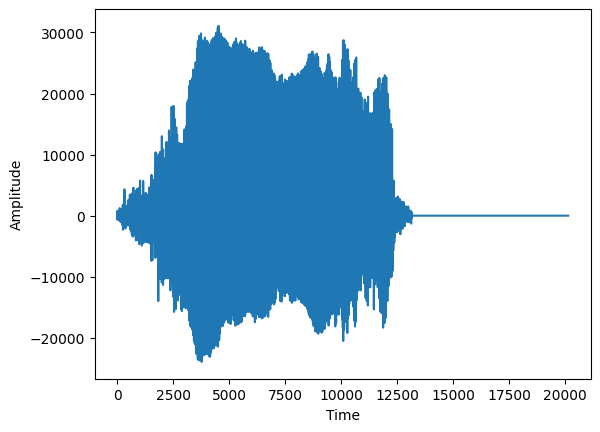

prediction result: [[-107 -128 -126 -108]], preediction label:0, true label: 71
shape of s[0]:(20150,)


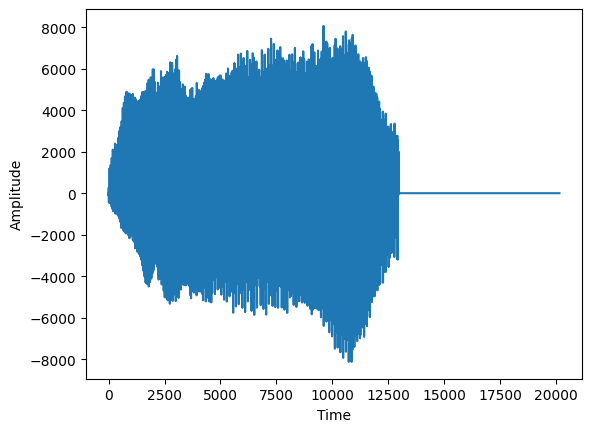

prediction result: [[ -70 -128 -128  -81]], preediction label:0, true label: 71
shape of s[0]:(20150,)


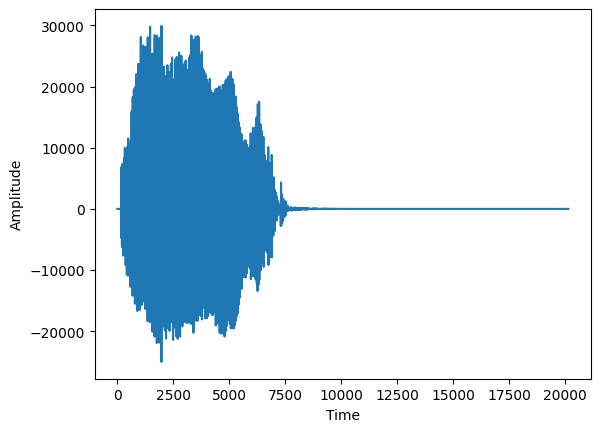

prediction result: [[-128 -128  -70  -86]], preediction label:2, true label: 71
shape of s[0]:(20150,)


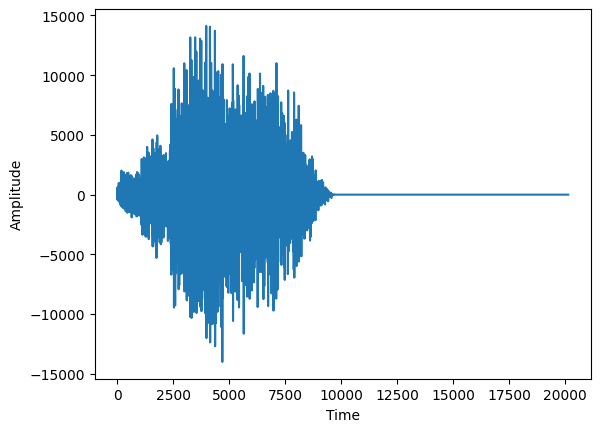

prediction result: [[-114 -128  -64  -81]], preediction label:2, true label: 71
shape of s[0]:(20150,)


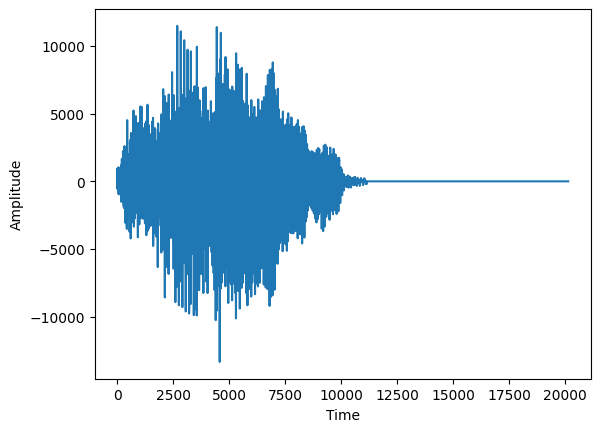

prediction result: [[ -97 -128  -98 -102]], preediction label:0, true label: 71
shape of s[0]:(20150,)


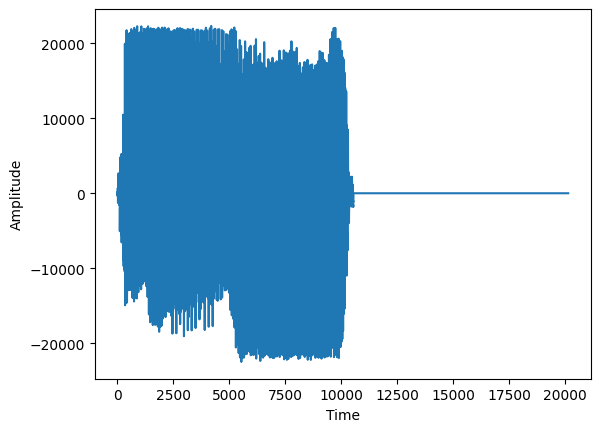

prediction result: [[ -81 -128 -128  -90]], preediction label:0, true label: 71
shape of s[0]:(20150,)


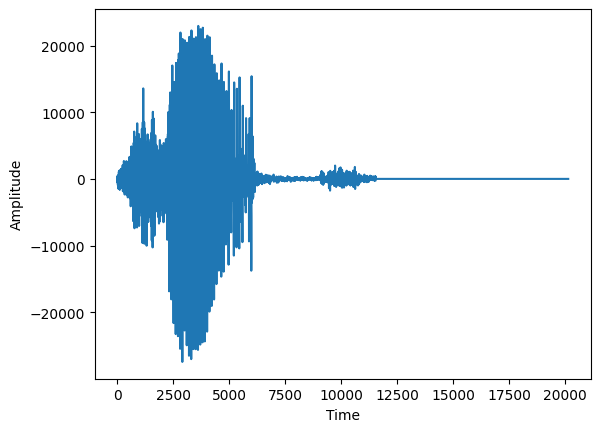

prediction result: [[-121 -128 -128 -111]], preediction label:3, true label: 71
shape of s[0]:(20150,)


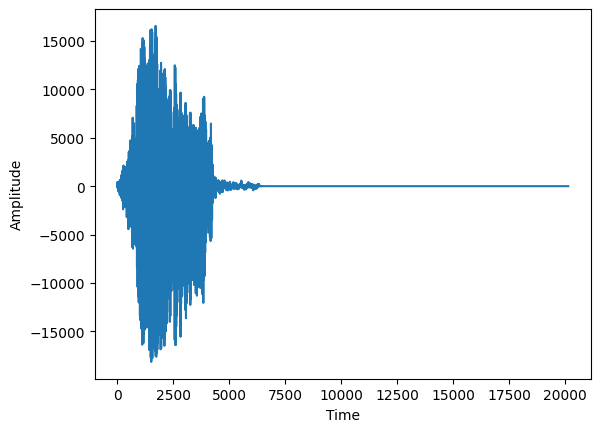

prediction result: [[-101 -128 -128 -107]], preediction label:0, true label: 71
shape of s[0]:(20150,)


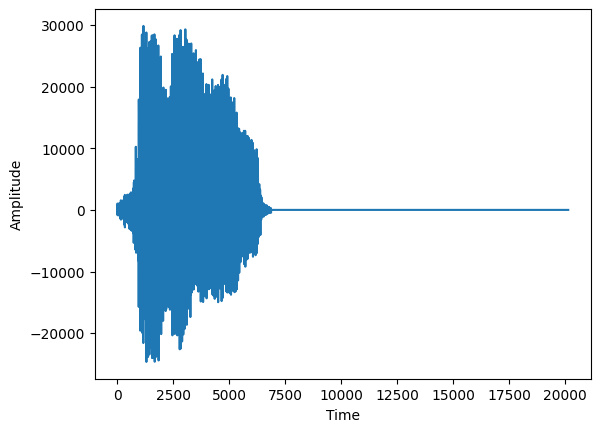

prediction result: [[-110 -128 -106 -112]], preediction label:2, true label: 71
shape of s[0]:(20150,)


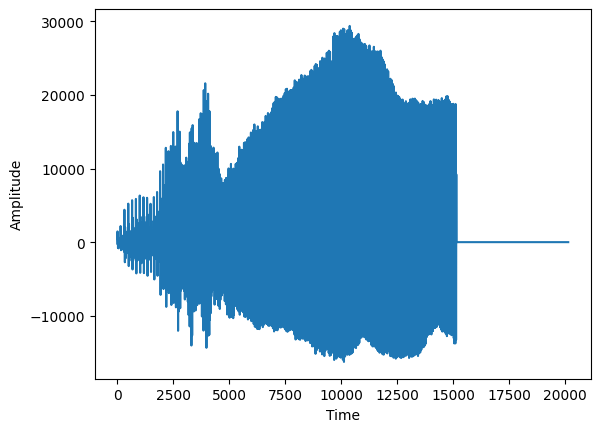

prediction result: [[ -70 -128 -128  -81]], preediction label:0, true label: 71
shape of s[0]:(20150,)


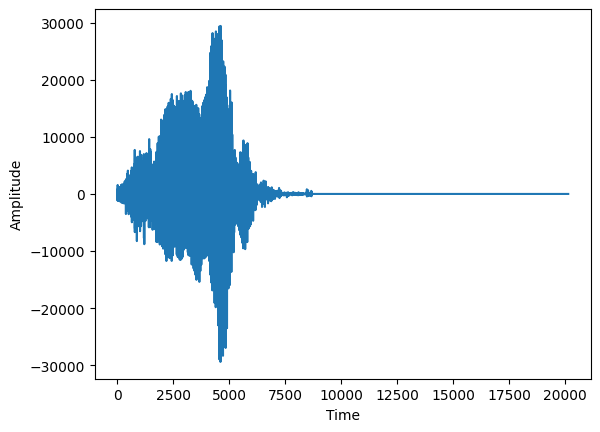

prediction result: [[-109 -128  -92 -102]], preediction label:2, true label: 71
shape of s[0]:(20150,)


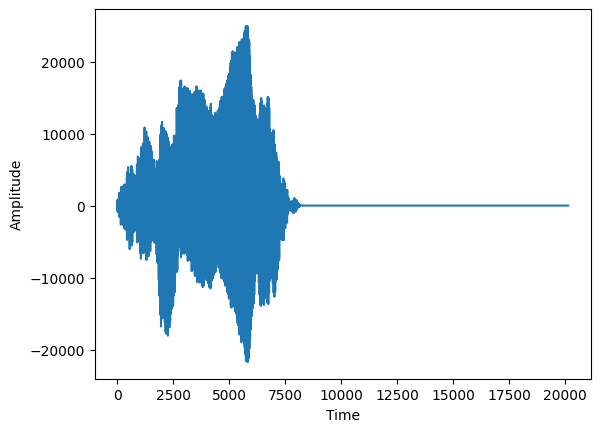

prediction result: [[-105 -128  -85  -97]], preediction label:2, true label: 71
shape of s[0]:(20150,)


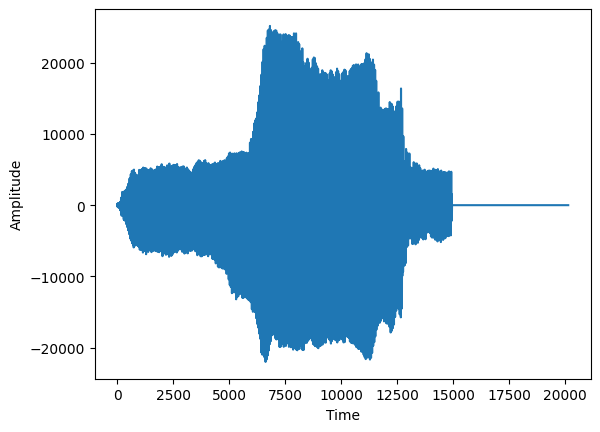

prediction result: [[ -94 -128 -126 -100]], preediction label:0, true label: 71
shape of s[0]:(20150,)


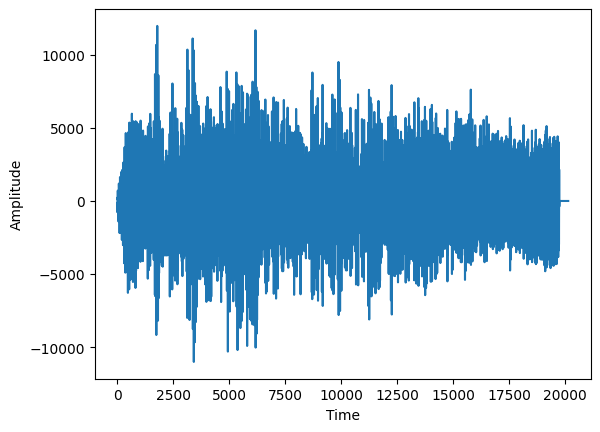

prediction result: [[ -61 -128 -128  -73]], preediction label:0, true label: 71
shape of s[0]:(20150,)


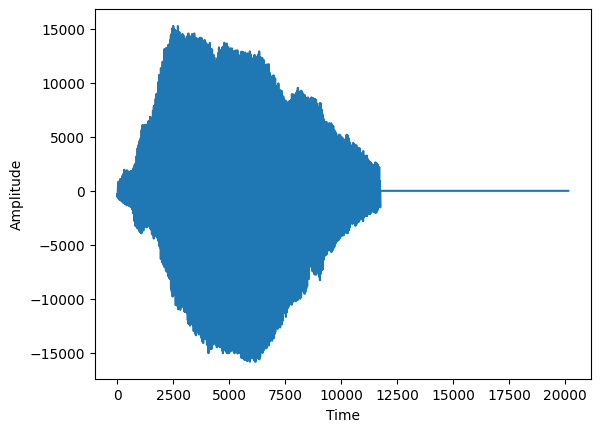

prediction result: [[-103 -128  -90  -98]], preediction label:2, true label: 71
shape of s[0]:(20150,)


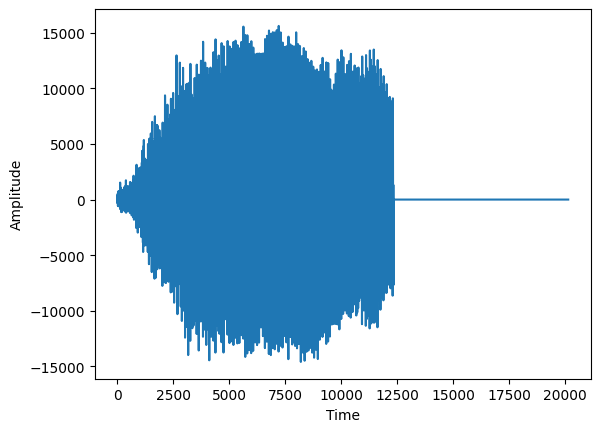

prediction result: [[ -70 -128 -128  -81]], preediction label:0, true label: 71
shape of s[0]:(20150,)


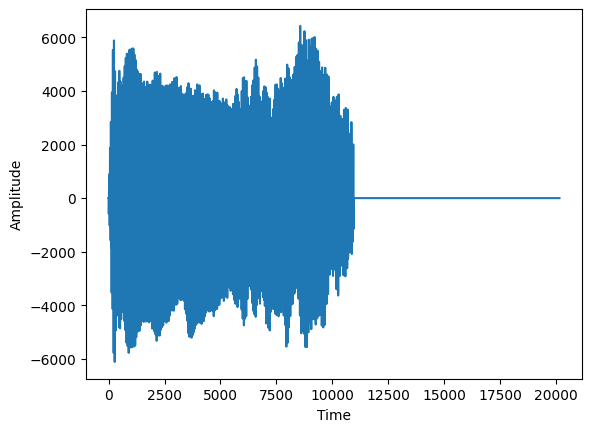

prediction result: [[ -76 -128 -128  -85]], preediction label:0, true label: 71
shape of s[0]:(20150,)


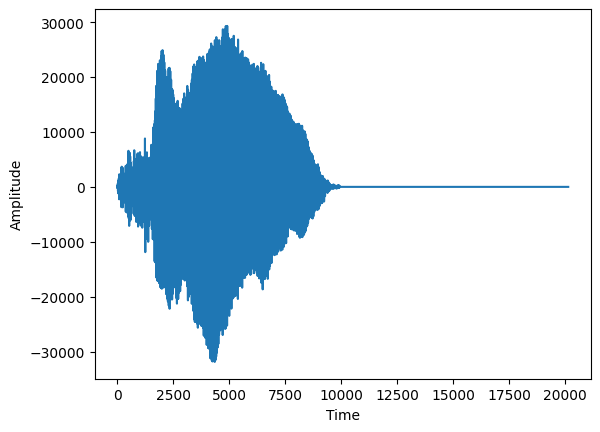

prediction result: [[-128 -128  -61  -77]], preediction label:2, true label: 71
shape of s[0]:(20150,)


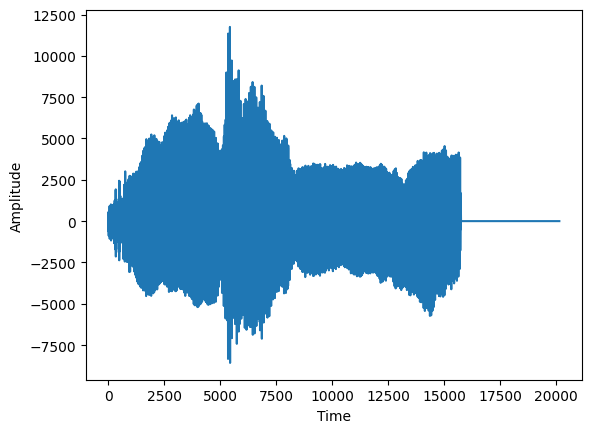

prediction result: [[-100 -128 -128 -105]], preediction label:0, true label: 71
shape of s[0]:(20150,)


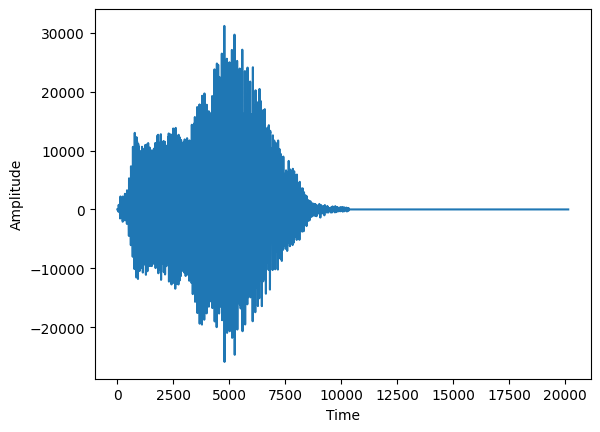

prediction result: [[-118 -128 -107 -111]], preediction label:2, true label: 71
shape of s[0]:(20150,)


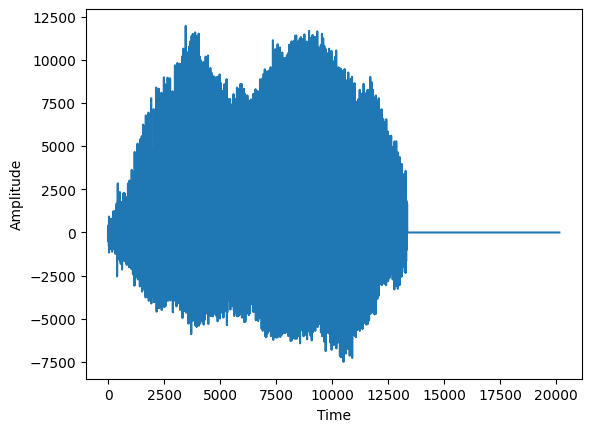

prediction result: [[ -91 -128  -95  -95]], preediction label:0, true label: 71
shape of s[0]:(20150,)


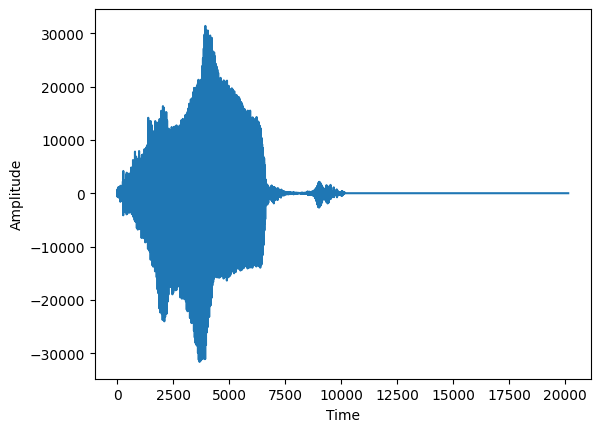

prediction result: [[-118 -128  -81  -89]], preediction label:2, true label: 71
shape of s[0]:(20150,)


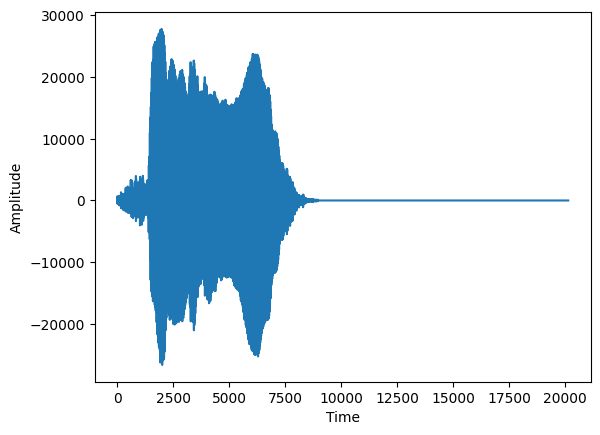

prediction result: [[-128 -128  -64  -84]], preediction label:2, true label: 71
english help speech test result is 34.65346534653465
predict wrong wav files list:
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/woman_clear_clip_help_004_71_middle.wav
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/man_clear_clip_help_027_71_middle.wav
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/man_clear_clip_help_010_71_middle.wav
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/woman_clear_clip_help_017_71_middle.wav
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_30225_no_repeat/middle/man_clear_clip_help_054_71_middle.wav
../../datasets/CurrentUse/wav_files/src_wavs/positive/help/help_english_71/s2_processed_

In [74]:
test_eng_help()

In [75]:
# scores = model.predict(sound, batch_size=len(sound), verbose=0);
# print(type(scores))
# print(scores.shape)

# for res in scores:
#     max_value = res.max()的
#     max_index = np.argmax(res)
#     print(f"max value:{max_value:.5f} and index is {max_index}")
#     print('\n'.join('{}: {:.5f}'.format(*k) for k in enumerate(res)))